## ENV AND FOLDERS

In [1]:
# Runtime and deps
!python -V
%pip -q install polars pyarrow pyyaml duckdb tqdm genson datamodel-code-generator tensorboard

# Logs
from torch.utils.tensorboard import SummaryWriter
LOG_DIR = "runs/cricket_bb"

# Folders
from pathlib import Path
for p in ["data/raw","data/parquet","data/extract","extract/zip_extract"]:
    Path(p).mkdir(parents=True, exist_ok=True)


Python 3.12.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 2.9 MB/s eta 0:00:00


## Download + Cricsheet JSONs

In [2]:
# ODI + T20 archives (adjust if needed)
!wget -O t20s_json.zip https://cricsheet.org/downloads/t20s_json.zip
!wget -O odis_json.zip https://cricsheet.org/downloads/odis_json.zip

import zipfile
with zipfile.ZipFile("odis_json.zip") as Z:
    Z.extractall("extract/zip_extract")


--2025-11-11 12:43:33--  https://cricsheet.org/downloads/t20s_json.zip
Resolving cricsheet.org (cricsheet.org)... 69.163.180.165
Connecting to cricsheet.org (cricsheet.org)|69.163.180.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15024032 (14M) [application/zip]
Saving to: ‘t20s_json.zip’

t20s_json.zip       100%[===================>]  14.33M  --.-KB/s    in 0.1s    

2025-11-11 12:43:33 (103 MB/s) - ‘t20s_json.zip’ saved [15024032/15024032]

--2025-11-11 12:43:33--  https://cricsheet.org/downloads/odis_json.zip
Resolving cricsheet.org (cricsheet.org)... 69.163.180.165
Connecting to cricsheet.org (cricsheet.org)|69.163.180.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14956391 (14M) [application/zip]
Saving to: ‘odis_json.zip’

odis_json.zip       100%[===================>]  14.26M  --.-KB/s    in 0.1s    

2025-11-11 12:43:33 (109 MB/s) - ‘odis_json.zip’ saved [14956391/14956391]



## Helpers, Data Ingestion

In [3]:
import json, yaml, glob, os
from pathlib import Path

def _load_obj(path: Path):
    txt = path.read_text(encoding="utf-8")
    return json.loads(txt) if path.suffix.lower()==".json" else yaml.safe_load(txt)

teams, outcomes, json_dicts, pps = [], [], [], []

for p in glob.glob("extract/zip_extract/*.json"):
    try:
        j = _load_obj(Path(p))
        dt = j["info"]["dates"][0]
        mid = j["info"]["match_type_number"]
        teams.extend(j["info"]["teams"])
        json_dicts.append(j)

        if "powerplays" in j["innings"][0]:
            pps.append({(dt, mid): j["innings"][0]["powerplays"]})

        for k in (j["info"]["outcome"] or {}).keys():
            if k not in ["by","winner"]:
                outcomes.append(j)
    except FileNotFoundError:
        print("missing:", p)
    except Exception as e:
        print("error:", e)


## Data rectifcation

In [4]:
# Detect duplicates among men's matches
u = {}
for i, d in enumerate(sorted(json_dicts, key=len)):
    if d["info"]["gender"] == "male":
        mid = d["info"]["match_type_number"]
        u.setdefault(mid, []).append((d, i))

dups = [k for k,v in u.items() if len(v)>1]
print("dups:", dups)

# Known fixes (from your notes)
ns = ["dates","gender","match_type_number","teams","match_type"]
ind_vs_nz = [u[3780][i][1] for i in range(2) if set(u[3780][i][0]["info"]["teams"])==set({"India","New Zealand"})]
ban_vs_nz = [u[4714][i][1] for i in range(2) if set(u[4714][i][0]["info"]["teams"])==set({"Bangladesh","New Zealand"})]
json_dicts[ban_vs_nz[0]]["info"]["match_type_number"] = 4715
json_dicts[ind_vs_nz[0]]["info"]["match_type_number"] = 3800
print("fixed ids:", ind_vs_nz, ban_vs_nz)


dups: [3780, 4714]
fixed ids: [318] [1463]


## SCHEMA creation

In [5]:
# @title
schema = {
  "$schema": "http://json-schema.org/draft-07/schema#",
  "title": "Cricsheet Match Data (v1.1.0)",
  "type": "object",
  "required": ["meta", "info", "innings"],
  "properties": {
    "meta": {
      "type": "object",
      "required": ["data_version", "created", "revision"],
      "properties": {
        "data_version": { "type": "string" },
        "created": { "type": "string", "format": "date" },
        "revision": { "type": "integer" }
      }
    },

    "info": {
      "type": "object",
      "required": ["balls_per_over", "dates", "gender", "match_type",
                   "outcome", "players", "registry", "season",
                    "team_type", "teams", "toss"], #"supersubs" is removed
      "properties": {
        "balls_per_over": { "type": "integer" },
        "bowl_out": {
          "type": "array",
          "items": {
            "type": "object",
            "properties": {
              "bowler": { "type": "string" },
              "outcome": { "type": "string", "enum": ["hit", "miss"] }
            },
            "required": ["bowler", "outcome"]
          }
        },
        "city": { "type": "string" },
        "dates": { "type": "array", "items": { "type": "string", "format": "date" } },
        "event": {
          "type": "object",
          "properties": {
            "name": { "type": "string" },
            "match_number": { "type": "integer" },
            "group": { "type": "string" },
            "stage": { "type": "string" }
          },
          "required": ["name"]
        },
        "gender": { "type": "string" },
        "match_type": { "type": "string" },
        "match_type_number": { "type": "integer" },
        "missing": { "type": "array" },
        "officials": {
          "type": "object",
          "properties": {
            "match_referees": { "type": "array", "items": { "type": "string" } },
            "reserve_umpires": { "type": "array", "items": { "type": "string" } },
            "tv_umpires": { "type": "array", "items": { "type": "string" } },
            "umpires": { "type": "array", "items": { "type": "string" } }
          }
        },
        "outcome": {
          "type": "object",
          "properties": {
            "winner": { "type": "string" },
            "result": { "type": "string" },
            "method": { "type": "string" },
            "eliminator": { "type": "string" },
            "bowl_out": { "type": "string" },
            "by": {
              "type": "object",
              "properties": {
                "innings": { "type": "integer" },
                "runs": { "type": "integer" },
                "wickets": { "type": "integer" }
              }
            }
          }
        },
        "overs": { "type": "integer" },
        "player_of_match": { "type": "array", "items": { "type": "string" } },
        "players": {
          "type": "object",
          "additionalProperties": { "type": "array", "items": { "type": "string" } }
        },
        "registry": {
          "type": "object",
          "properties": {
            "people": {
              "type": "object",
              "additionalProperties": { "type": "string" }
            }
          }
        },
        "season": { "type": "string" },
        "supersubs": {
          "type": "object",
          "additionalProperties": { "type": "string" }
        },
        "team_type": { "type": "string" },
        "teams": { "type": "array", "items": { "type": "string" }, "minItems": 2, "maxItems": 2 },
        "toss": {
          "type": "object",
          "required": ["decision", "winner"],
          "properties": {
            "uncontested": { "type": "boolean" },
            "decision": { "type": "string", "enum": ["bat", "field"] },
            "winner": { "type": "string" }
          }
        },
        "venue": { "type": "string" }
      }
    },

    "innings": {
      "type": "array",
      "items": {
        "type": "object",
        "required": ["team"],
        "properties": {
          "team": { "type": "string" },
          "overs": {
            "type": "array",
            "items": {
              "type": "object",
              "required": ["over", "deliveries"],
              "properties": {
                "over": { "type": "number" },
                "deliveries": {
                  "type": "array",
                  "items": {
                    "type": "object",
                    "required": ["batter", "bowler", "non_striker", "runs"],
                    "properties": {
                      "batter": { "type": "string" },
                      "bowler": { "type": "string" },
                      "non_striker": { "type": "string" },
                      "runs": {
                        "type": "object",
                        "required": ["batter", "extras", "total"],
                        "properties": {
                          "batter": { "type": "integer" },
                          "extras": { "type": "integer" },
                          "total": { "type": "integer" },
                          "non_boundary": { "type": "boolean" }
                        }
                      },
                      "extras": {
                        "type": "object",
                        "properties": {
                          "byes": { "type": "integer" },
                          "legbyes": { "type": "integer" },
                          "noballs": { "type": "integer" },
                          "penalty": { "type": "integer" },
                          "wides": { "type": "integer" }
                        }
                      },
                      "replacements": {
                        "type": "object",
                        "properties": {
                          "match": {
                            "type": "array",
                            "items": {
                              "type": "object",
                              "required": ["in", "out", "reason", "team"],
                              "properties": {
                                "in": { "type": "string" },
                                "out": { "type": "string" },
                                "reason": { "type": "string" },
                                "team": { "type": "string" }
                              }
                            }
                          },
                          "role": {
                            "type": "array",
                            "items": {
                              "type": "object",
                              "required": ["in", "reason", "role"],
                              "properties": {
                                "in": { "type": "string" },
                                "out": { "type": "string" },
                                "reason": { "type": "string" },
                                "role": { "type": "string" }
                              }
                            }
                          }
                        }
                      },
                      "review": {
                        "type": "object",
                        "properties": {
                          "batter": { "type": "string" },
                          "by": { "type": "string" },
                          "decision": { "type": "string", "enum": ["struck down", "upheld"] },
                          "umpire": { "type": "string" },
                          "umpires_call": { "type": "boolean" }
                        }
                      },
                      "wickets": {
                        "type": "array",
                        "items": {
                          "type": "object",
                          "required": ["kind", "player_out"],
                          "properties": {
                            "fielders": {
                              "type": "array",
                              "items": { "type": "object", "properties": { "name": { "type": "string" } } }
                            },
                            "kind": { "type": "string" },
                            "player_out": { "type": "string" }
                          }
                        }
                      }
                    }
                  }
                }
              }
            }
          },
          "absent_hurt": { "type": "array", "items": { "type": "string" } },
          "declared": { "type": "boolean" },
          "forfeited": { "type": "boolean" },
          "penalty_runs": {
            "type": "object",
            "properties": { "pre": { "type": "integer" }, "post": { "type": "integer" } }
          },
          "powerplays": {
            "type": "array",
            "items": {
              "type": "object",
              "properties": {
                "from": { "type": "number" },
                "to": { "type": "number" },
                "type": { "type": "string" }
              }
            }
          },
          "miscounted_overs": {
            "type": "object",
            "additionalProperties": {
              "type": "object",
              "properties": {
                "balls": { "type": "number" },
                "umpire": { "type": "string" }
              },
              "required": ["balls"]
            }
          },
          "target": {
            "type": "object",
            "properties": { "overs": { "type": "integer" }, "runs": { "type": "integer" } }
          },
          "super_over": { "type": "boolean" }
        }
      }
    }
  }
}


In [6]:
## Dump schema
files = [
    ("schema_cric.json", {"indent": 4}),
]

for filename, options in files:
    with open(filename, "w") as f:
        json.dump(schema, f, **options)

## Outcome extract + Schema Validation

In [7]:
from typing import Dict, Any
def extract_outcome_columns(match: dict) -> dict:
    info = match.get("info", {})
    outcome = (info.get("outcome") or {})
    teams = list(info.get("teams") or [])

    result = (outcome.get("result") or "").lower() or None
    winner = outcome.get("winner") or outcome.get("bowl_out") or outcome.get("eliminator")
    by = outcome.get("by") or {}
    method = outcome.get("method") or None
    used_bowlout = "bowl_out" in outcome and bool(outcome.get("bowl_out"))
    used_eliminator = "eliminator" in outcome and bool(outcome.get("eliminator"))

    lose = None
    if winner and len(teams)==2 and (winner in teams):
        lose = teams[0] if teams[1]==winner else teams[1]

    is_tie = (result=="tie")
    no_result = (result=="no result")

    return {
        "winner": winner,
        "loser": lose,
        "is_initial_tie": bool(is_tie),
        "no_result": bool(no_result),
        "method": method if method else None,
        "used_bowlout": used_bowlout,
        "used_eliminator": used_eliminator,
        "win_by_runs": by.get("runs") if winner and ("runs" in by) else None,
        "win_by_wickets": by.get("wickets") if winner and ("wickets" in by) else None,
    }

def validate_match_schema(match_obj: Dict[str, Any], schema: Dict[str, Any]) -> None:
    """
    Validate a single Cricsheet match dict against the provided JSON schema.
    Raises jsonschema.ValidationError if invalid.
    """
    try:
        import jsonschema
    except ImportError as e:
        raise RuntimeError("Please `pip install jsonschema` to validate the match schema.") from e
    jsonschema.validate(instance=match_obj, schema=schema)

## Delivery parsers

In [8]:
import numpy as np
from typing import Any, Dict, List, Optional
import pandas as pd

def _is_legal_delivery(d): return not (d.get("extras", {}) or {}).get("wides") and not (d.get("extras", {}) or {}).get("noballs")

def _wickets_in_delivery(d):
    wk = d.get("wickets", [])
    return len(wk) if isinstance(wk,list) else int(bool(wk))

def _delivery_extras_detail(d):
    e = d.get("extras", {}) or {}
    return {
        "bye": int(e.get("byes", 0) or 0),
        "legbye": int(e.get("legbyes", 0) or 0),
        "noball": int(e.get("noballs", 0) or 0),
        "wide": int(e.get("wides", 0) or 0),
        "penalty": int(e.get("penalty", 0) or 0),
    }

def match_to_balls_df(
    match_obj: Dict[str, Any],
    match_id: Optional[str | int] = None,
    validate: bool = False,
    schema: Optional[Dict[str, Any]] = None,
) -> pd.DataFrame:
    """
    Flatten a single match JSON into a ball-wise DataFrame suitable for EDA.

    Rows: one per DELIVERY (incl. wides/no-balls as separate rows).
    Key columns:
      - match_id, date, gender, match_type, balls_per_over
      - innings (1/2), team_batting, over (0-based int)
      - ball_in_over_any (1..N incl. illegal), ball_idx_any (1.. incl. illegal)
      - legal_delivery (bool), ball_idx_legal (1.. for legal balls; NaN for illegal rows)
      - runs_batter (int), runs_extras (int), runs_total (int)
      - runs_no_extras (== runs_batter)
      - wickets_this_ball (int), wickets_down (cumulative, legal or illegal rows both count)
      - cum_runs_total (incl. extras), cum_runs_batter (excl. extras)
      - innings_total_runs (incl. extras & penalty runs; same value repeated)
      - abs_legal_idx (absolute legal-ball index within innings; NaN for illegal rows)
    """
    if validate:
        if schema is None:
            raise ValueError("Provide `schema` when validate=True.")
        validate_match_schema(match_obj, schema)

    info = match_obj["info"]
    bpo = int(info["balls_per_over"])
    date = pd.to_datetime(info["dates"][0])
    gender = str(info.get("gender", "unknown"))
    match_type = str(info.get("match_type", "unknown"))
    innings_list = match_obj["innings"]
    if match_id is None:
      match_id = info["match_type_number"]
    rows: List[Dict[str, Any]] = []

    for inn_idx, inn in enumerate(innings_list, start=1):
        batting_team = inn["team"]
        overs = inn.get("overs", [])
        # pre/post penalty (not in deliveries)
        pen = inn.get("penalty_runs", {}) or {}
        pen_pre, pen_post = int(pen.get("pre", 0) or 0), int(pen.get("post", 0) or 0)

        ball_idx_any = 0
        legal_idx = 0
        wickets_down = 0
        cum_runs_total = pen_pre  # pre-penalty applied at start of innings
        cum_runs_batter = 0

        # first pass: gather rows
        for over_obj in overs:
            over_no = int(over_obj["over"])
            deliveries = over_obj.get("deliveries", [])
            for j, d in enumerate(deliveries, start=1):
                ball_idx_any += 1
                is_legal = _is_legal_delivery(d)
                if is_legal:
                    legal_idx += 1

                runs_bat = int(d["runs"]["batter"])
                runs_ex = int(d["runs"]["extras"])
                runs_tot = int(d["runs"]["total"])
                w_this = _wickets_in_delivery(d)

                cum_runs_total += runs_tot
                cum_runs_batter += runs_bat
                wickets_down += w_this

                extras_typed = _delivery_extras_detail(d)
                abs_legal_idx = legal_idx if is_legal else np.nan

                rows.append(
                    {
                        "match_id": match_id,
                        "date": date,
                        "gender": gender,
                        "match_type": match_type,
                        "balls_per_over": bpo,
                        "innings": inn_idx,
                        "team_batting": batting_team,
                        "over": over_no,
                        "ball_in_over_any": j,
                        "ball_idx_any": ball_idx_any,
                        "legal_delivery": bool(is_legal),
                        "ball_idx_legal": abs_legal_idx,
                        "runs_batter": runs_bat,
                        "runs_extras": runs_ex,
                        "runs_total": runs_tot,
                        "runs_no_extras": runs_bat,
                        "wickets_this_ball": w_this,
                        "wickets_down": wickets_down,
                        "cum_runs_total": cum_runs_total,
                        "cum_runs_batter": cum_runs_batter,
                        "extras_bye": extras_typed["bye"],
                        "extras_legbye": extras_typed["legbye"],
                        "extras_noball": extras_typed["noball"],
                        "extras_wide": extras_typed["wide"],
                        "extras_penalty": extras_typed["penalty"],
                    }
                )

        # add post-penalty to the final total and backfill a constant column
        if rows:
            inn_mask = [(r["innings"] == inn_idx) for r in rows]
            # figure innings total incl. post penalty:
            innings_total_runs = (rows[-1]["cum_runs_total"] if inn_mask[-1] else 0) + pen_post
            for r in rows:
                if r["innings"] == inn_idx:
                    r["innings_total_runs"] = innings_total_runs

    df = pd.DataFrame(rows)

    # absolute legal index within innings (1..), computed on legal rows only
    # (already captured as ball_idx_legal). For convenience keep a copy:
    df["abs_legal_idx"] = df["ball_idx_legal"]

    # Sort for stability
    sort_cols = ["match_id", "innings", "over", "ball_in_over_any", "ball_idx_any"]
    present = [c for c in sort_cols if c in df.columns]
    df = df.sort_values(present).reset_index(drop=True)

    outcome = extract_outcome_columns(match_obj)
    df = df.assign(**outcome)
    return df

## PP rules

In [9]:
import numpy as np
from datetime import date
from typing import Any, Dict, Optional

# Regime cut points
D1 = date(2005,7,8); D2 = date(2011,10,1); D3 = date(2012,10,30); D4 = date(2015,7,5)

def _parse_match_date(match_obj: Dict[str, Any]) -> date:
    dstr = (match_obj.get("info",{}).get("dates") or ["1900-01-01"])[0]
    y,m,d = map(int, dstr.split("-"))
    return date(y,m,d)

def _pp_rule_params(d: date):
    # Returns (S_overs, contiguous_start, window_end_over)
    # if d < D1: return (15, True, None)
    # if D1 < d < D2: return (20, False, None)
    # if D2 < d < D3: return (20, False, 40)
    # if D3 <= d < D4: return (15, False, 40)
    return (10, True, None)

def _scheduled_overs_from_type(mt: Optional[str]) -> int:
    if not mt: return 50
    mt = mt.lower()
    if "t20" in mt: return 20
    if "odi" in mt or "one-day" in mt or "one day" in mt: return 50
    if "hundred" in mt: return 20
    return 50

def _overfloat_to_abs_legal_index(oflt: float, bpo: int):
    import math
    over_i = int(math.floor(oflt)); dec = round((oflt - over_i) + 1e-9, 1)
    ball = int(round(dec * 10)); ball = 1 if ball < 1 else min(ball, bpo)
    abs_idx = over_i * bpo + ball
    return over_i, ball, abs_idx

def _powerplay_abs_legal_indices(pp_list, bpo: int, max_abs_legal: int):
    idx = set()
    for pp in pp_list or []:
        start = float(pp.get("from")); end = float(pp.get("to"))
        _,_,a0 = _overfloat_to_abs_legal_index(start, bpo)
        _,_,a1 = _overfloat_to_abs_legal_index(end, bpo)
        if a1 < a0: a0, a1 = a1, a0
        for a in range(a0, a1+1):
            if a <= max_abs_legal: idx.add(a)
    return np.array(sorted(idx), dtype=int)

def add_pp_frac_by_date_rules(balls_df: pd.DataFrame,
                              match_obj_by_id: Dict[Any, Dict[str, Any]]) -> pd.DataFrame:
    """
    pp_frac = PP legal balls remaining after current legal index / all legal balls remaining.
    Uses date regimes + scheduled overs. Works per match_id × innings.
    """
    df = balls_df.copy()
    df["legal_delivery"] = df["legal_delivery"].astype(bool)

    df = df.sort_values(["match_id","innings","abs_legal_idx"])
    df["ball_idx_legal_ffill"] = df.groupby(["match_id","innings"])["ball_idx_legal"].ffill().astype("Int64")

    df["pp_frac"] = np.nan
    for mid, gmatch in df.groupby("match_id", sort=False):
        mobj = match_obj_by_id.get(mid, {})
        d = _parse_match_date(mobj)
        S_overs, contiguous_start, window_end_over = _pp_rule_params(d)

        mtype = gmatch["match_type"].dropna().iloc[0] if "match_type" in gmatch else mobj.get("info",{}).get("match_type")
        sched_overs = _scheduled_overs_from_type(mtype)

        for inn, g in gmatch.groupby("innings", sort=False):
            bpo = int(g["balls_per_over"].dropna().iloc[0])
            total_legal_sched = sched_overs * bpo
            max_abs = int(np.nanmax(g["ball_idx_legal"].to_numpy()))

            pp_list = (mobj.get("innings", []) or [{}])[inn-1].get("powerplays", []) or []
            pp_abs = _powerplay_abs_legal_indices(pp_list, bpo=bpo, max_abs_legal=max_abs)

            legal_mask = g["legal_delivery"].to_numpy()
            abs_idx = g["ball_idx_legal"].to_numpy().astype("float64")

            vals = np.full(len(g), np.nan, float)
            if pp_abs.size > 0:
                legal_pos = np.where(legal_mask)[0]
                L = abs_idx[legal_pos].astype("int64")
                pp_after = pp_abs.size - np.searchsorted(pp_abs, L, side="right")
                legal_after = max_abs - L
                with np.errstate(divide="ignore", invalid="ignore"):
                    frac = np.where(legal_after > 0, pp_after / legal_after, 0.0)
                vals[legal_pos] = frac
            else:
                vals[np.where(legal_mask)[0]] = 0.0

            sub = g.assign(_pp_frac_legal=vals).sort_values(["innings","ball_idx_legal","legal_delivery"])
            sub["_pp_frac_filled"] = sub["_pp_frac_legal"].ffill()
            df.loc[sub.index, "pp_frac"] = sub["_pp_frac_filled"].to_numpy()

    df["pp_frac"] = df["pp_frac"].fillna(0.0).clip(0.0, 1.0)
    return df


## Train set build

In [10]:
import pandas as pd

def _infer_scheduled_overs(mt: str) -> int:
    if not mt: return 50
    mt = mt.lower()
    if "t20" in mt: return 20
    if "odi" in mt or "one-day" in mt or "one day" in mt: return 50
    if "hundred" in mt: return 20
    return 50

def build_features_for_training(balls_df: pd.DataFrame, drop_last_state: bool=True) -> pd.DataFrame:
    df = balls_df.copy()
    df = df[df["legal_delivery"]==True].copy()

    # Natural order
    sort_cols = ["match_id","innings"]
    sort_cols += ["abs_legal_idx"] if "abs_legal_idx" in df.columns else ["over","ball_idx_legal"]
    df = df.sort_values(sort_cols)

    # Start-of-ball wickets
    df["wickets_down_start"] = (
        df.groupby(["match_id","innings"])["wickets_down"]
          .shift(1, fill_value=0).astype(int)
    )

    # Scheduled balls per innings
    sched_map = (
        df.groupby("match_id")["match_type"]
          .first().apply(_infer_scheduled_overs).to_dict()
    )
    df["scheduled_overs"] = df["match_id"].map(sched_map).astype(int)
    df["scheduled_total_balls"] = df["scheduled_overs"] * df["balls_per_over"].astype(int)

    # Balls remaining at start of current ball
    balls_done_before = df["ball_idx_legal"].astype(int) - 1
    df["balls_rem"] = (df["scheduled_total_balls"] - balls_done_before).clip(lower=0).astype(int)

    # Wickets remaining at start
    df["wickets_rem"] = (10 - df["wickets_down_start"]).clip(0,10).astype(int)

    # Target: total batter runs at end minus start-of-ball cumulative batter runs
    df["cum_batter_start"] = df.groupby(["match_id","innings"])["cum_runs_batter"].shift(1, fill_value=0)
    end_bat = (
        df.groupby(["match_id","innings"])["cum_runs_batter"].last()
          .rename("total_batter_runs_end").reset_index()
    )
    df = df.merge(end_bat, on=["match_id","innings"], how="left")
    df["y_runs_to_end_no_extras"] = (df["total_batter_runs_end"] - df["cum_batter_start"]).clip(lower=0).astype(float)

    if drop_last_state:
        df = df[df["balls_rem"] > 1].copy()

    keep = ["match_id","date","innings","team_batting","ball_idx_legal",
            "balls_rem","wickets_down_start","wickets_rem","pp_frac","y_runs_to_end_no_extras"]
    have = [c for c in keep if c in df.columns]
    out = df[have].rename(columns={"wickets_down_start":"wickets_down"})
    return out.sort_values(["match_id","innings","ball_idx_legal"]).reset_index(drop=True)


## Full Ball df

In [11]:
import pandas as pd

# Map id -> raw json
jsons = {j["info"]["match_type_number"]: j for j in json_dicts}

# Flatten all matches
all_balls_df = pd.concat([match_to_balls_df(j) for j in json_dicts], ignore_index=True)
all_balls_df.to_parquet("all_balls_df.parquet")

# Filter: remove curtailed (method present), keep men, innings 1, legal balls
dl_ids = all_balls_df[all_balls_df["method"].notna()]["match_id"].unique()
balls_df_filtered = all_balls_df[~all_balls_df["match_id"].isin(dl_ids)]
balls_men_inn1_df = (
    balls_df_filtered[
      (balls_df_filtered["gender"]=="male") &
      (balls_df_filtered["innings"]==1) &
      (balls_df_filtered["legal_delivery"])
    ]
    .reset_index(drop=True)
)

# PP fraction via date-based rules
balls_men_inn1_df = add_pp_frac_by_date_rules(balls_men_inn1_df, jsons)

# Identify miscounted overs (ball_idx_legal==301 without metadata)
mco_df = balls_men_inn1_df[balls_men_inn1_df["ball_idx_legal"]==301][
    ["ball_idx_legal","abs_legal_idx","wickets_down","match_id","pp_frac","wickets_this_ball"]
]
for mco_id in mco_df["match_id"]:
    if "miscounted_overs" not in (jsons[mco_id]["innings"][0]).keys():
        print(mco_id)

# Drop those matches for now
balls_men_inn1_df_rem_mco = balls_men_inn1_df[~balls_men_inn1_df["match_id"].isin(mco_df["match_id"])].reset_index(drop=True)

# Build features
balls_feat = build_features_for_training(balls_men_inn1_df_rem_mco, drop_last_state=False).copy()

### INNINGS 2
balls_men_inn2_df = (
    balls_df_filtered[
      (balls_df_filtered["gender"]=="male") &
      (balls_df_filtered["innings"]==2) &
      (balls_df_filtered["legal_delivery"])
    ]
    .reset_index(drop=True)
)

# PP fraction via date-based rules
balls_men_inn2_df = add_pp_frac_by_date_rules(balls_men_inn2_df, jsons)

# Identify miscounted overs (ball_idx_legal==301 without metadata)
mco_df = balls_men_inn2_df[balls_men_inn2_df["ball_idx_legal"]==301][
    ["ball_idx_legal","abs_legal_idx","wickets_down","match_id","pp_frac","wickets_this_ball"]
]
for mco_id in mco_df["match_id"]:
    if "miscounted_overs" not in (jsons[mco_id]["innings"][0]).keys():
        print(mco_id)

# Drop those matches for now
balls_men_inn2_df_rem_mco = balls_men_inn2_df[~balls_men_inn2_df["match_id"].isin(mco_df["match_id"])].reset_index(drop=True)

# Build features
balls_feat_2 = build_features_for_training(balls_men_inn2_df_rem_mco, drop_last_state=False).copy()



2420
2589


## Runs heatmap

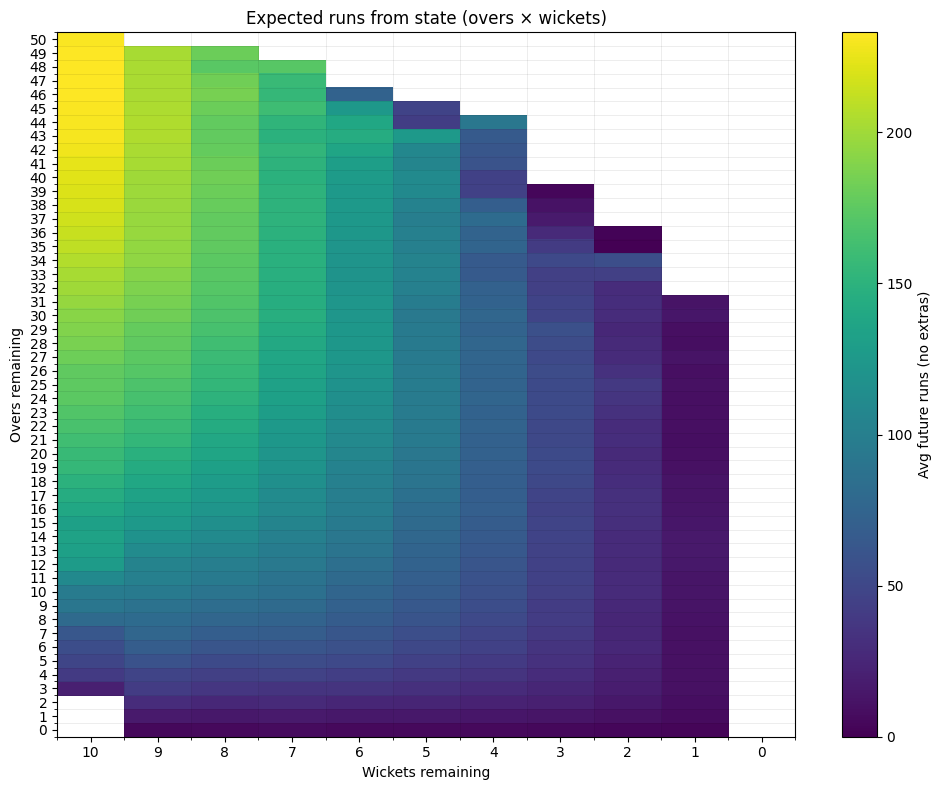

In [13]:
import numpy as np, matplotlib.pyplot as plt

def plot_runs_surface_heatmap(df, balls_per_over=6, min_count=5, cmap="viridis"):
    d = df.copy()
    d["overs_remaining"] = (d["balls_rem"] / balls_per_over).astype(int)
    mean_tbl = (
        d.groupby(["overs_remaining","wickets_rem"])["y_runs_to_end_no_extras"]
         .mean().unstack("wickets_rem")
    )
    cnt_tbl = d.groupby(["overs_remaining","wickets_rem"]).size().unstack("wickets_rem")
    mean_tbl = mean_tbl.where(cnt_tbl >= min_count)

    all_overs = np.arange(min(0, mean_tbl.index.min()), mean_tbl.index.max()+1)
    all_wkts  = np.arange(0, 11)
    mean_tbl = mean_tbl.reindex(index=all_overs, columns=all_wkts)

    plt.figure(figsize=(10,8))
    im = plt.imshow(mean_tbl.values, aspect="auto", origin="lower", interpolation="nearest", cmap=cmap)
    plt.colorbar(im, label="Avg future runs (no extras)")
    ax = plt.gca(); ax.invert_xaxis()
    ax.set_xticks(np.arange(-0.5, mean_tbl.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, mean_tbl.shape[0], 1), minor=True)
    ax.grid(which="minor", color="k", alpha=0.1, linewidth=0.5)
    plt.xticks(ticks=np.arange(len(all_wkts)), labels=all_wkts)
    plt.yticks(ticks=np.arange(len(all_overs)), labels=all_overs)
    plt.xlabel("Wickets remaining"); plt.ylabel("Overs remaining")
    plt.title("Expected runs from state (overs × wickets)")
    plt.tight_layout(); plt.show()
    return mean_tbl

_ = plot_runs_surface_heatmap(balls_feat, min_count=5)


## Train-val split

In [14]:
import numpy as np, pandas as pd
from typing import Tuple
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def split_by_date_and_balance_train(
    df: pd.DataFrame,
    p_train: float=0.70, p_val: float=0.15, p_test: float=0.15,
    balls_per_over: int=6, drop_zero_wkts: bool=True,
    balance_mode: str="weights", train_rows: int|None=None, random_state: int=42
) -> Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame,pd.Timestamp,pd.Timestamp]:
    assert abs(p_train+p_val+p_test-1.0) < 1e-6

    mdates = df.groupby("match_id")["date"].min().sort_values()
    n = len(mdates)
    i1 = max(1, int(round(n*p_train)))
    i2 = max(i1+1, int(round(n*(p_train+p_val))))
    d1 = mdates.iloc[i1-1]
    d2 = mdates.iloc[i2-1] if i2-1 < n else mdates.iloc[-1] + pd.Timedelta(days=1)

    m2d = mdates.to_dict()
    df = df.assign(_match_date=df["match_id"].map(m2d))

    train = df[df["match_id"].isin(mdates[mdates < d1].index)].copy()
    val   = df[df["match_id"].isin(mdates[(mdates >= d1) & (mdates < d2)].index)].copy()
    test  = df[df["match_id"].isin(mdates[mdates >= d2].index)].copy()

    tr = train.copy()
    tr["overs_rem"] = np.ceil(tr["balls_rem"]/balls_per_over).astype(int).clip(1,50)
    tr["wk_bin"] = pd.cut(tr["wickets_rem"], bins=[0,5,10], right=True, labels=[0,1])
    tr["ov_bin"] = pd.cut(tr["overs_rem"], bins=[0,10,20,30,40,50], right=True, labels=[0,1,2,3,4])
    tr["y_bin"]  = pd.cut(tr["y_runs_to_end_no_extras"], bins=[0,100,200,250,300,350,1e9], right=False, labels=[0,1,2,3,4,5])

    if balance_mode=="downsample" and train_rows:
        counts = tr.groupby(["ov_bin","wk_bin","y_bin"]).size()
        nonempty = counts[counts>0]
        if nonempty.empty:
            train_out = tr.drop(columns=["overs_rem","wk_bin","ov_bin","y_bin","_match_date"])
            train_out["sample_weight"]=1.0
        else:
            target = train_rows if train_rows is not None else int(nonempty.sum())
            C = len(nonempty); base = max(1, target//C); rem = max(0, target - base*C)

            takes = nonempty.copy().astype(int); takes[:] = np.minimum(nonempty.values, base)
            leftover = (nonempty - takes).clip(lower=0)
            if rem>0 and leftover.sum()>0:
                order = leftover.sort_values(ascending=False).index.tolist()
                idx = 0
                while rem>0 and leftover.sum()>0:
                    cell = order[idx]
                    if leftover[cell] > 0:
                        takes[cell]+=1; leftover[cell]-=1; rem-=1
                    idx = (idx+1) % len(order)

            parts=[]
            for (cell,k) in takes.items():
                if k<=0: continue
                ob,wb,yb = cell
                grp = tr[(tr["ov_bin"]==ob)&(tr["wk_bin"]==wb)&(tr["y_bin"]==yb)]
                if grp.empty: continue
                parts.append(grp if len(grp)<=k else grp.sample(n=k, random_state=random_state))
            train_sel = pd.concat(parts, ignore_index=False) if parts else tr
            sel_counts = train_sel.groupby(["ov_bin","wk_bin","y_bin"]).size().rename("n")
            train_sel = train_sel.merge(sel_counts, on=["ov_bin","wk_bin","y_bin"], how="left")
            train_sel["sample_weight"] = (1.0/train_sel["n"]) * sel_counts.mean()
            train_out = train_sel.drop(columns=["overs_rem","wk_bin","ov_bin","y_bin","n","_match_date"])
    else:
        # weights mode or no balancing requested
        train_out = tr.drop(columns=["overs_rem","wk_bin","ov_bin","y_bin","_match_date"])
        if "sample_weight" not in train_out.columns:
            train_out["sample_weight"] = 1.0

    cols = df.columns.drop("_match_date")
    cols_out = list(cols) + (["sample_weight"] if "sample_weight" not in cols else [])
    train_out = train_out.reindex(columns=cols_out).fillna({"sample_weight":1.0})
    val = val.reindex(columns=cols); test = test.reindex(columns=cols)
    return train_out.sort_index(), val.sort_index(), test.sort_index(), d1, d2



# ---- rename columns to expected names ----
def _prep(df_in: pd.DataFrame):
    df = df_in.copy()
    df = df.rename(columns={
        'balls_rem':'b',
        'wickets_rem':'w',
        'pp_frac':'pp',                   # this is PP BALLS remaining
        'y_runs_to_end_no_extras':'runs'
    }).copy()
    if 'weight' not in df.columns:
        df['weight'] = 1.0
    # clean
    df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=['b','w','pp','runs','weight'])
    df['weight'] = np.clip(df['weight'].astype(float), 1e-8, None)
    return df


## Split and diagnostics

In [15]:
balls_feat = balls_feat.sort_values(["date","match_id","ball_idx_legal"]).reset_index(drop=True)
balls_feat["ball_id"] = balls_feat.index

train_df, val_full, test_full, d1, d2 = split_by_date_and_balance_train(
    balls_feat, train_rows=200_000, p_train=0.7, p_val=0.15, p_test=0.15
)

# Sample smaller val/test to match your workflow
val_df  = val_full.sample(n=len(train_df)//5, random_state=42).copy()
test_df = test_full.sample(n=len(train_df)//5, random_state=42).copy()
for t in (val_df, test_df):
    t["sample_weight"] = 1.0

# Basic sanity checks
d = train_df.copy()
m = (d["balls_rem"]>0) & (d["wickets_rem"]>0)
d = d[m]
den = 6.0 * d["balls_rem"].astype(float)
frac = (d["y_runs_to_end_no_extras"]/den).clip(1e-6, 1-1e-6)
print("y_frac std:", frac.std(), "min/max:", frac.min(), frac.max())
print("unique balls_rem:", d["balls_rem"].nunique(),
      "wickets_rem:", d["wickets_rem"].nunique(),
      "pp_frac:", d["pp_frac"].nunique())
print("weights stats:", d.get("sample_weight", pd.Series(1, index=d.index)).describe())

# Convert pp_frac share -> absolute PP balls
# for t in (train_df, val_df, test_df):
#     t["pp_frac"] = t["pp_frac"] * t["balls_rem"]

# train_df["pp_frac"] = train_df["pp_frac"].clip(0, 60)
# val_df["pp_frac"] = val_df["pp_frac"].clip(0, 60)
train_df["pp_frac"] = 0
val_df["pp_frac"] =  0

train_df["pp_frac"] = (61 - train_df["ball_idx_legal"]).clip(lower=0).astype(int)
val_df["pp_frac"] = (61 - val_df["ball_idx_legal"]).clip(lower=0).astype(int)
test_df["pp_frac"] = (61 - test_df["ball_idx_legal"]).clip(lower=0).astype(int)

train = _prep(train_df)
val   = _prep(val_df)

print(d1, d2)

y_frac std: 0.07269765274592113 min/max: 1e-06 0.999999
unique balls_rem: 300 wickets_rem: 10 pp_frac: 9702
weights stats: count    448285.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: sample_weight, dtype: float64
2019-02-22 00:00:00 2023-01-23 00:00:00


In [16]:
balls_feat_2 = balls_feat_2.sort_values(["date","match_id","ball_idx_legal"]).reset_index(drop=True)
balls_feat_2["ball_id"] = balls_feat_2.index

train_df_2, val_full_2, test_full_2, d1_2, d2_2 = split_by_date_and_balance_train(
    balls_feat_2, train_rows=200_000, p_train=0.7, p_val=0.15, p_test=0.15
)

# Sample smaller val/test to match your workflow
val_df_2 = val_full_2.sample(n=len(train_df_2)//5, random_state=42).copy()
test_df_2 = test_full_2.sample(n=len(train_df_2)//5, random_state=42).copy()
for t in (val_df_2, test_df_2):
    t["sample_weight"] = 1.0

# Basic sanity checks
d = train_df_2.copy()
m = (d["balls_rem"]>0) & (d["wickets_rem"]>0)
d = d[m]
den = 6.0 * d["balls_rem"].astype(float)
frac = (d["y_runs_to_end_no_extras"]/den).clip(1e-6, 1-1e-6)
print("y_frac std:", frac.std(), "min/max:", frac.min(), frac.max())
print("unique balls_rem:", d["balls_rem"].nunique(),
      "wickets_rem:", d["wickets_rem"].nunique(),
      "pp_frac:", d["pp_frac"].nunique())
print("weights stats:", d.get("sample_weight", pd.Series(1, index=d.index)).describe())

# Convert pp_frac share -> absolute PP balls
# for t in (train_df, val_df, test_df):
#     t["pp_frac"] = t["pp_frac"] * t["balls_rem"]

# train_df["pp_frac"] = train_df["pp_frac"].clip(0, 60)
# val_df["pp_frac"] = val_df["pp_frac"].clip(0, 60)
train_df_2["pp_frac"] = 0
val_df_2["pp_frac"] =  0

train_df_2["pp_frac"] = (61 - train_df_2["ball_idx_legal"]).clip(lower=0).astype(int)
val_df_2["pp_frac"] = (61 - val_df_2["ball_idx_legal"]).clip(lower=0).astype(int)
test_df_2["pp_frac"] = (61 - test_df_2["ball_idx_legal"]).clip(lower=0).astype(int)

train_2 = _prep(train_df_2)
val_2   = _prep(val_df_2)

print(d1_2, d2_2)

y_frac std: 0.050000719635827987 min/max: 1e-06 0.999999
unique balls_rem: 300 wickets_rem: 10 pp_frac: 12317
weights stats: count    382862.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: sample_weight, dtype: float64
2019-03-02 00:00:00 2023-01-29 00:00:00


## Train the model

In [17]:
# @title
import pandas as pd

# rows: overs left 50..0 ; cols: wickets lost 0..9
data = {
  50:[100.0,93.4,85.1,74.9,62.7,49.0,34.9,22.0,11.9,4.7],
  49:[ 99.1,92.6,84.5,74.4,62.5,48.9,34.9,22.0,11.9,4.7],
  48:[ 98.1,91.7,83.8,74.0,62.2,48.4,34.9,22.0,11.9,4.7],
  47:[ 97.1,90.9,83.2,73.5,61.9,48.6,34.9,22.0,11.9,4.7],
  46:[ 96.0,90.0,82.5,73.0,61.6,48.4,34.8,22.0,11.9,4.7],
  45:[ 95.0,89.1,81.8,72.5,61.3,48.4,34.8,22.0,11.9,4.7],
  44:[ 93.9,88.2,81.0,72.0,61.0,48.3,34.8,22.0,11.9,4.7],
  43:[ 92.8,87.3,80.3,71.5,60.7,47.9,34.7,22.0,11.9,4.7],
  42:[ 91.7,86.3,79.5,70.9,60.3,47.9,34.7,22.0,11.9,4.7],
  41:[ 90.5,85.3,78.7,70.3,59.9,47.4,34.6,22.0,11.9,4.7],
  40:[ 89.3,84.2,77.8,69.6,59.5,47.0,34.6,22.0,11.9,4.7],
  39:[ 88.0,83.1,76.9,69.0,59.1,46.7,34.5,22.0,11.9,4.7],
  38:[ 86.7,82.0,76.1,68.3,58.7,46.3,34.4,22.0,11.9,4.7],
  37:[ 85.4,80.9,75.0,67.6,58.2,46.9,34.4,21.9,11.9,4.7],
  36:[ 84.0,79.6,74.0,66.8,57.7,46.4,34.3,21.9,11.9,4.7],
  35:[ 82.7,78.5,73.0,66.0,57.2,46.4,34.2,21.9,11.9,4.7],
  34:[ 81.3,77.2,72.0,65.2,56.6,45.9,34.1,21.9,11.9,4.7],
  33:[ 79.8,75.9,70.9,64.4,56.0,45.4,34.0,21.9,11.9,4.7],
  32:[ 78.3,74.6,69.7,63.5,55.4,45.0,33.9,21.9,11.9,4.7],
  31:[ 76.8,73.4,68.7,62.7,54.7,44.5,33.7,21.9,11.9,4.7],
  30:[ 75.1,71.8,67.3,61.6,54.1,44.3,33.5,21.8,11.9,4.7],
  29:[ 73.4,70.1,66.0,60.6,53.4,43.8,33.2,21.8,11.9,4.7],
  28:[ 71.8,68.8,64.8,59.5,52.6,43.3,33.2,21.8,11.9,4.7],
  27:[ 70.1,67.2,63.4,58.4,51.8,42.8,33.0,21.8,11.9,4.7],
  26:[ 68.3,65.6,62.0,57.2,50.9,42.3,32.8,21.7,11.9,4.7],
  25:[ 66.5,63.9,60.5,56.0,50.0,42.2,32.6,21.6,11.9,4.7],
  24:[ 64.6,62.2,59.0,54.7,49.0,41.6,32.3,21.6,11.9,4.7],
  23:[ 62.7,60.4,57.4,53.4,48.0,40.9,32.0,21.4,11.9,4.7],
  22:[ 60.7,58.6,55.8,52.0,47.0,40.2,31.6,21.4,11.9,4.7],
  21:[ 58.7,57.0,54.1,50.6,45.8,39.4,31.2,21.3,11.9,4.7],
  20:[ 56.6,54.8,52.4,49.1,44.6,38.6,30.8,21.2,11.9,4.7],
  19:[ 54.4,52.8,50.5,47.5,43.9,40.0,33.1,21.1,11.9,4.7],
  18:[ 52.2,50.7,48.6,45.9,42.0,36.8,29.8,20.9,11.9,4.7],
  17:[ 49.9,48.5,46.7,44.1,40.6,35.8,29.2,20.7,11.9,4.7],
  16:[ 47.6,46.3,44.7,42.3,39.1,34.7,28.5,20.5,11.8,4.7],
  15:[ 45.2,44.1,42.6,40.5,37.6,33.5,27.8,20.2,11.8,4.7],
  14:[ 42.7,41.7,40.4,38.6,36.0,32.3,26.9,19.8,11.7,4.7],
  13:[ 40.2,39.3,38.1,36.5,34.2,30.8,26.1,19.3,11.7,4.7],
  12:[ 37.6,36.8,35.8,34.3,32.3,29.4,25.1,19.0,11.6,4.7],
  11:[ 34.9,34.2,33.4,31.9,29.4,27.2,24.0,18.5,11.5,4.7],
  10:[ 32.1,31.6,30.8,29.8,28.3,26.1,22.8,17.9,11.4,4.7],
   9:[ 29.2,28.8,28.2,27.1,26.1,24.2,21.4,17.1,11.2,4.7],
   8:[ 26.4,26.0,25.5,24.8,23.8,22.3,19.9,16.2,11.0,4.7],
   7:[ 23.4,23.1,22.7,22.2,21.4,20.1,18.2,15.2,10.5,4.7],
   6:[ 20.3,20.1,19.8,19.4,18.8,17.8,16.4,13.9,10.2,4.6],
   5:[ 17.2,17.0,16.8,16.5,16.1,15.4,14.3,12.5, 9.4,4.6],
   4:[ 14.0,13.9,13.7,13.5,13.2,12.7,12.0,10.7, 8.4,4.6],
   3:[ 10.6,10.5,10.4,10.3,10.2, 9.9, 9.5, 8.7, 7.2,4.2],
   2:[  7.2, 7.1, 7.1, 7.0, 6.8, 6.6, 6.2, 6.0, 5.5,3.7],
   1:[  3.6, 3.6, 3.6, 3.6, 3.5, 3.5, 3.4, 3.6, 3.2,2.5],
   0:[  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0],
}

# build DataFrame with desired ordering
dls_df = pd.DataFrame.from_dict(data, orient="index").sort_index(ascending=False)
dls_df.index.name = "overs_left"
dls_df.columns = pd.Index(range(10), name="wickets_lost")

dls_df.columns = [str(int(x) + 1) for x in dls_df.columns[::-1]]
dls_df["0"] = 0
dls_df


,10,9,8,7,6,5,4,3,2,1,0
overs_left,,,,,,,,,,,
50,100.0,93.4,85.1,74.9,62.7,49.0,34.9,22.0,11.9,4.7,0
49,99.1,92.6,84.5,74.4,62.5,48.9,34.9,22.0,11.9,4.7,0
48,98.1,91.7,83.8,74.0,62.2,48.4,34.9,22.0,11.9,4.7,0
47,97.1,90.9,83.2,73.5,61.9,48.6,34.9,22.0,11.9,4.7,0
46,96.0,90.0,82.5,73.0,61.6,48.4,34.8,22.0,11.9,4.7,0
45,95.0,89.1,81.8,72.5,61.3,48.4,34.8,22.0,11.9,4.7,0
44,93.9,88.2,81.0,72.0,61.0,48.3,34.8,22.0,11.9,4.7,0
43,92.8,87.3,80.3,71.5,60.7,47.9,34.7,22.0,11.9,4.7,0
42,91.7,86.3,79.5,70.9,60.3,47.9,34.7,22.0,11.9,4.7,0


/tmp/ipython-input-3076020967.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', 10)                  # 10 distinct colors


1 29.0
2 50.285714285714285
3 58.73684210526316
4 124.0
5 184.0
6 143.9
7 188.5
8 223.0
9 207.6875
10 232.701244813278


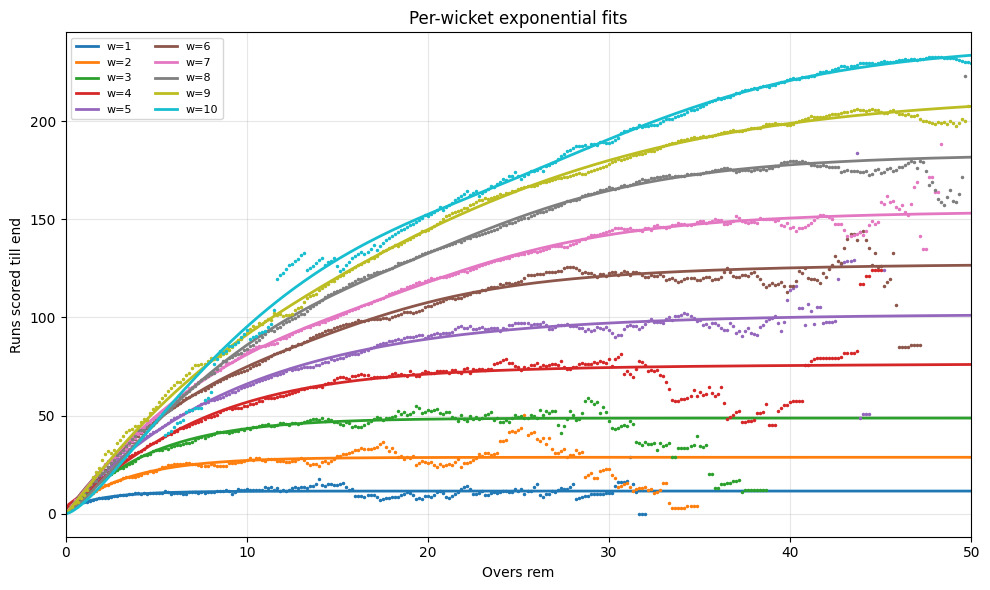

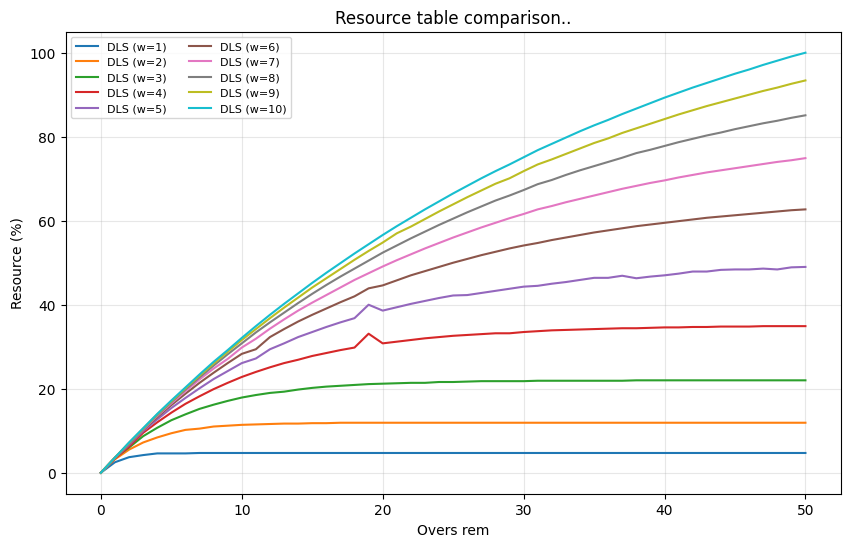

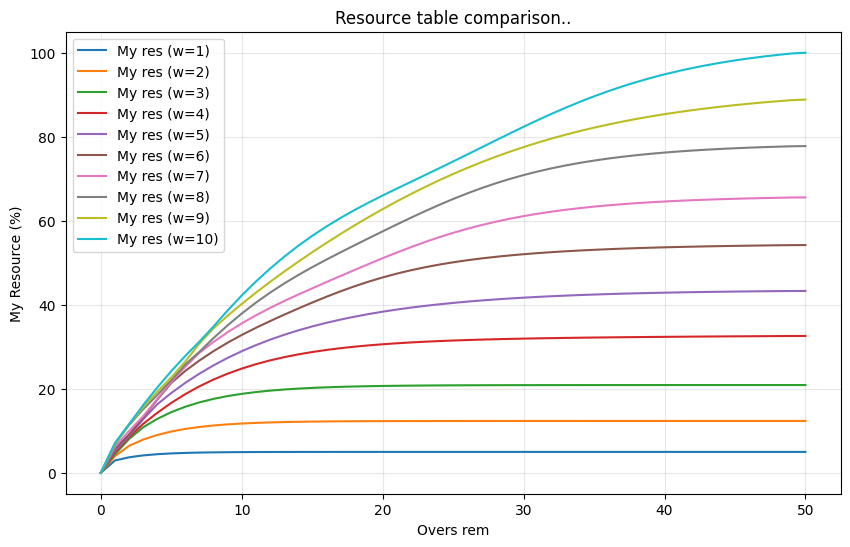

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:

from IPython.display import display, Math
import numpy as np

from IPython.display import display, Math
def get_df(adf, w_rem = 5, per_over = True):
  df = pd.DataFrame(adf[w_rem])
  # df: index = balls_remaining, column 'runs' (or use df.iloc[:,0] if unnamed)
  balls_per_over = 6
  if per_over:
    avg_runs_by_over = (
        df['runs']
        .groupby(np.floor_divide(df.index.astype(int), 6))
        .mean()
        .sort_index(ascending=False)   # optional
    )
    avg_runs_by_over.index.name = 'overs_rem'
    return avg_runs_by_over
  else:
    return df


import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from scipy.optimize import curve_fit
T_BALLS = 300.0
def exp_model(b, A, k, g): return A * (1 - np.exp(-k * (b / T_BALLS)))**g
def exp2_model(X, A1, k1, g1, A2, k2, g2, A3, k3, g3, eta ):
      # X is a tuple/array: (b, pp)
    b, pp = X
    eta = 0
    u = np.clip(b / T_BALLS, 0.0, 1.0)
    ret = A1 * (1 - np.exp(-k1*u))**g1 + A2 * (1 - np.exp(-k2*u))**g2 + A3 * (1 - np.exp(-k3*u))**g3
    return ret #**eta
# def exp2_model(X, A1,k1,g1, A2,k2,g2, A3,k3,g3, eta):
#     # X is a tuple/array: (b, pp)
#     b, pp = X
#     u = np.clip((b/T_BALLS + eta*(pp/60)), 0.0, 1.0) #/2.0
#     return (A1 * (1 - np.exp(-k1*u))**g1
#           + A2 * (1 - np.exp(-k2*u))**g2
#           + A3 * (1 - np.exp(-k3*u))**g3)

def phase_weight(b):
    if b>240: return 3.0   # emphasize PP
    if b>60: return 1.5    # middle
    return 2.5             # death


cmap = cm.get_cmap('tab10', 10)                  # 10 distinct colors
colors = {w: cmap((w-1) % 10) for w in range(1,11)}

fig, ax = plt.subplots(figsize=(10,6))
fits = {}     # w -> (A,k,g)
fit_cov = {}  # w -> covariance or None
train_cpy = train.copy()
# train_cpy['pp'] = 0

for w1 in range(1, 11):
    d = train_cpy[train_cpy['w']==w1][['b','pp','runs']].reset_index(drop = True).groupby(['b','pp']).agg(runs=('runs','mean'), n=('runs','size')).reset_index()
    if d.empty: continue
    b = d['b'].to_numpy(float); y = d['runs'].to_numpy(float)
    pp = d['pp'].to_numpy(float)
    sigma = (1.0 / np.sqrt(np.maximum(d['n'].to_numpy(float),1.0)))* np.array([phase_weight(b_rem) for b_rem in b])

    A0 = max(y.max(), 1.0) #max(np.percentile(y, 99.5), 1.0)
    print(w1, A0)
    p0 = [0.6*A0, 0.08,1.2, 0.4*A0, 1.2, 1.2, 0.5*A0, 1.2, 1.2, 0.9]          # slow+fast
    # bounds: A>0, k>0, g in [0.5, 3.5]
    A_hi = max(5*A0, A0+10.0)
    bounds = ([A0*0.2, 1e-3, 1e-2, 1e-5, 1e-4, 1e-2, A0*0.3, 1e-3, 1e-2, 0.0], [A_hi, 4.0, 10.0, A_hi, 20.0, 55.0, A_hi*4, 5.0, 8.0, 1.0])

    (A1,k1,g1, A2,k2, g2,A3,k3, g3 , eta), _ = curve_fit(exp2_model, (b,pp), y, p0=p0, bounds=bounds,
                                  absolute_sigma=False, maxfev=20000, sigma=sigma,)
    fits[w1] = (A1.item(),k1.item(),g1.item(),A2.item(),k2.item(),g2.item(), A3.item(),k3.item(), g3.item(), eta.item())

    col = colors[w1]
    ax.plot(b, y, 'o', ms=1.5, color=col, label='_nolegend_')
    bx = np.linspace(0, 300, 301)
    ppx = np.array([0 for i in range(241)] + [i for i in range(1, 61)])
    ax.plot(bx, exp2_model((bx, ppx), A1,k1,g1,A2,k2,g2,A3,k3, g3, eta), '-', lw=2.0, color=col, label=f"w={w1}")
fits[0] = (0,0,0,0,0,0,0,0,0, 0)
max_balls = 300         # balls remaining
ticks = np.arange(0, max_balls + 1, 6)     # every over
ax.set_xlim(0, max_balls)
ax.set_xticks(ticks[::10])
ax.set_xticklabels((ticks[::10] // 6).astype(int))   # show over count
ax.grid(True, which='both', alpha=0.3)
ax.set_xlabel("Overs rem")
ax.set_ylabel("Runs scored till end")
ax.set_title("Per-wicket exponential fits")
ax.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()
import collections

bx = np.linspace(1, 300, 300)
ppx = np.array([0 for i in range(240)] + [i for i in range(1, 61)])
rows = { w: [0] + [ q.item() for q in list(exp2_model((bx,ppx), *params ))] for w, params in fits.items()}
rows[0] = [0 for i in range(301)]
rows = collections.OrderedDict(sorted(rows.items()))
gamma = 0.9
pred_df = pd.DataFrame(rows) #**gamma
myres_df = pred_df*100/(pred_df.max().max())
myres_df = myres_df.iloc[::-1, ::-1]
myres_df[:] = myres_df.apply(lambda x: sorted(x, reverse = True), axis=1, result_type='expand')
myres_df

# df: index = balls_remaining (300..0), columns = wickets_remaining (10..0)

def to_overs_wickets(df):
    idx = df.index.astype(int)
    ow = (
        df.assign(overs_rem=idx // 6)     # 300..295 -> 50, 294..289 -> 49, ...
          .groupby('overs_rem', as_index=True)
          .mean()                         # average over each 6-ball block
          .sort_index(ascending=False)    # 50..0
    )
    # optional: keep wicket columns ordered 10..0
    ow = ow.reindex(sorted(ow.columns, reverse=True), axis=1)
    ow.index.name = 'overs_rem'
    ow.columns.name = 'wickets_rem'
    ow.loc[0] = 0
    return ow

overs_wickets = to_overs_wickets(myres_df)
## Resource table to a df
res_tab  = overs_wickets.copy()



fig, ax = plt.subplots(figsize = (10, 6))
for w1 in range(1, 11):
  ax.plot(dls_df[str(w1)], label=f"DLS (w={w1})", linestyle='-')

## ax.plot(dls_df[str()], label=f"DLS (w={w2})", linestyle='-')

ax.set_title(f"Resource table comparison..")
ax.set_xlabel("Overs rem")
ax.set_ylabel("Resource (%)")
ax.legend(ncol=2, fontsize=8)
ax.grid(True, alpha=0.3)

plt.show()


fig, ax = plt.subplots(figsize = (10, 6))
for w1 in range(1, 11):
  ax.plot(res_tab[w1], label=f"My res (w={w1})", linestyle='-')
    #ax.plot(dls_df[str(w2)], label=f"DLS (w={w2})", linestyle='-')

ax.set_title(f"Resource table comparison..")
ax.set_xlabel("Overs rem")
ax.set_ylabel("My Resource (%)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

T_BALLS = 300  # or 120

# 1) Show the model equation
display(Math(rf"""
y(b; w)=\sum_{{i=1}}^3 A_{{w,i}}\Big(1-e^{{-k_{{w,i}}\; b/{T_BALLS}}}\Big)^{{g_{{w,i}}}}
"""))

# 2) Linewise parameters
def fits_to_latex_lines(fits, decimals=3):
    fmt = f"{{:.{decimals}f}}"
    lines = []
    for w in sorted(fits):
        A1,k1,g1,A2,k2,g2,A3,k3,g3,eta= fits[w]
        line = rf"""
        w={w}:\;(A_1,k_1,g_1)=({fmt.format(A1)},{fmt.format(k1)},{fmt.format(g1)}),\;
        (A_2,k_2,g_2)=({fmt.format(A2)},{fmt.format(k2)},{fmt.format(g2)}),\;
        (A_3,k_3,g_3)=({fmt.format(A3)},{fmt.format(k3)},{fmt.format(g3)})
        """
        lines.append(line.strip())
    return r"\begin{aligned}" + r"\\ ".join(lines) + r"\end{aligned}"

display(Math(fits_to_latex_lines(fits, decimals=3)))


In [19]:
print([fits[i][9] for i in range(0, 11)])

[0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]


/tmp/ipython-input-2712214467.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', 10)                  # 10 distinct colors


1 37.0
2 44.0
3 53.1980125
4 84.35595238095237
5 113.2833636363636
6 124.43708333333332
7 175.15535714285727
8 197.0676666666666
9 190.81568807339448
10 196.03266844009366


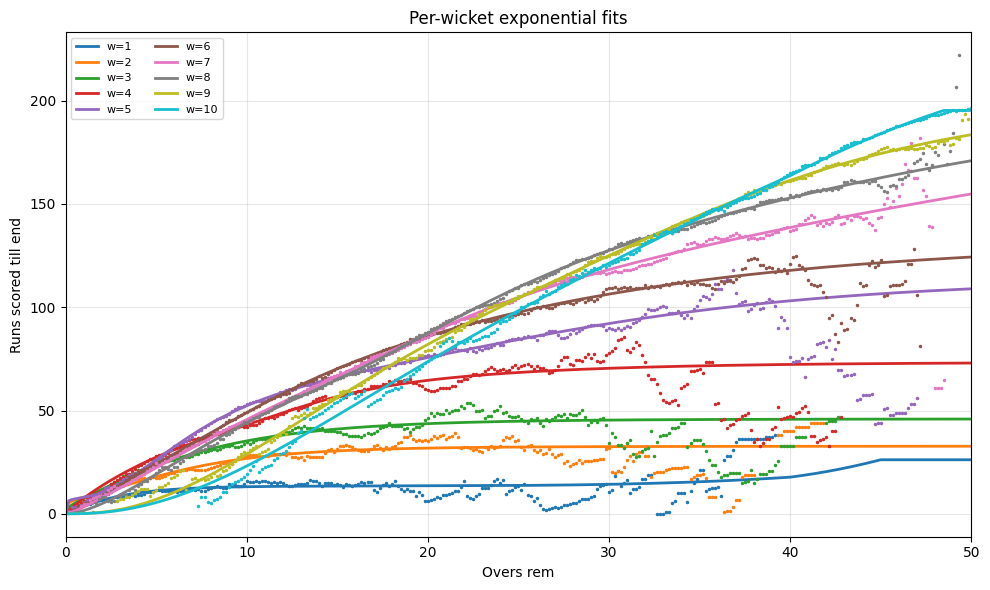

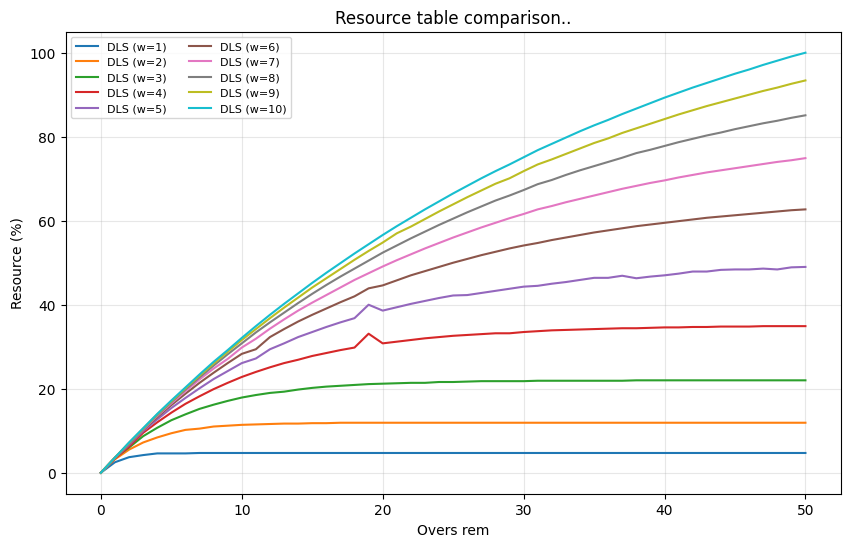

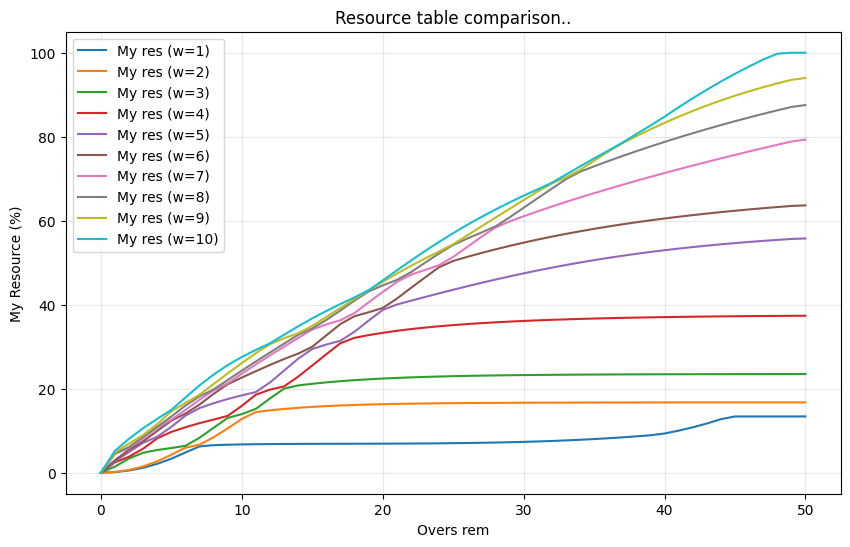

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
# @title
## 2nd innings


from IPython.display import display, Math
import numpy as np

from IPython.display import display, Math
def get_df(adf, w_rem = 5, per_over = True):
  df = pd.DataFrame(adf[w_rem])
  # df: index = balls_remaining, column 'runs' (or use df.iloc[:,0] if unnamed)
  balls_per_over = 6
  if per_over:
    avg_runs_by_over = (
        df['runs']
        .groupby(np.floor_divide(df.index.astype(int), 6))
        .mean()
        .sort_index(ascending=False)   # optional
    )
    avg_runs_by_over.index.name = 'overs_rem'
    return avg_runs_by_over
  else:
    return df


import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from scipy.optimize import curve_fit
T_BALLS = 300.0
def exp_model(b, A, k, g): return A * (1 - np.exp(-k * (b / T_BALLS)))**g
def exp2_model(b, A1, k1, g1, A2, k2, g2, A3, k3, g3 ):
    u = np.clip(b / T_BALLS, 0.0, 1.0)
    return A1 * (1 - np.exp(-k1*u))**g1 + A2 * (1 - np.exp(-k2*u))**g2 + A3 * (1 - np.exp(-k3*u))**g3

def exp2_model(X, A1,k1,g1, A2,k2,g2, A3,k3,g3, eta):
    # X is a tuple/array: (b, pp)
    b, pp = X
    u = np.clip((b/T_BALLS + eta*(pp/60)), 0.0, 1.0) #/2.0
    return (A1 * (1 - np.exp(-k1*u))**g1
          + A2 * (1 - np.exp(-k2*u))**g2
          + A3 * (1 - np.exp(-k3*u))**g3)

def phase_weight(b):
    if b>240: return 3.0   # emphasize PP
    if b>60: return 1.5    # middle
    return 2.5             # death


cmap = cm.get_cmap('tab10', 10)                  # 10 distinct colors
colors = {w: cmap((w-1) % 10) for w in range(1,11)}

fig, ax = plt.subplots(figsize=(10,6))
fits = {}     # w -> (A,k,g)
fit_cov = {}  # w -> covariance or None
train_cpy = train_2.copy()
# train_cpy['pp'] = 0

for w1 in range(1, 11):
    d = train_cpy[train_cpy['w']==w1][['b','pp','runs']].reset_index(drop = True).groupby(['b','pp']).agg(runs=('runs','mean'), n=('runs','size')).reset_index()
    if d.empty: continue
    b = d['b'].to_numpy(float); y = d['runs'].to_numpy(float)
    pp = d['pp'].to_numpy(float)
    sigma = (1.0 / np.sqrt(np.maximum(d['n'].to_numpy(float),1.0)))* np.array([phase_weight(b_rem) for b_rem in b])

    A0 = max(np.percentile(y, 99.5), 1.0)
    print(w1, A0)
    p0 = [0.6*A0, 0.08,1.2, 0.4*A0, 1.2, 1.2, 0.5*A0, 1.2, 1.2, 0.2]          # slow+fast
    # bounds: A>0, k>0, g in [0.5, 3.5]
    A_hi = max(5*A0, A0+10.0)
    bounds = ([A0*0.2, 1e-3, 1e-2, 1e-5, 1e-4, 1e-2, A0*0.3, 1e-3, 1e-2, 0.0], [A_hi, 4.0, 10.0, A_hi, 20.0, 55.0, A_hi*4, 5.0, 8.0, 1.0])

    (A1,k1,g1, A2,k2, g2,A3,k3, g3 , eta), _ = curve_fit(exp2_model, (b,pp), y, p0=p0, bounds=bounds,
                                  absolute_sigma=False, maxfev=20000, sigma=sigma,)
    fits[w1] = (A1.item(),k1.item(),g1.item(),A2.item(),k2.item(),g2.item(), A3.item(),k3.item(), g3.item(), eta.item())

    col = colors[w1]
    ax.plot(b, y, 'o', ms=1.5, color=col, label='_nolegend_')
    bx = np.linspace(0, 300, 301)
    ppx = np.array([0 for i in range(241)] + [i for i in range(1, 61)])
    ax.plot(bx, exp2_model((bx, ppx), A1,k1,g1,A2,k2,g2,A3,k3, g3, eta), '-', lw=2.0, color=col, label=f"w={w1}")
fits[0] = (0,0,0,0,0,0,0,0,0, 0)
max_balls = 300         # balls remaining
ticks = np.arange(0, max_balls + 1, 6)     # every over
ax.set_xlim(0, max_balls)
ax.set_xticks(ticks[::10])
ax.set_xticklabels((ticks[::10] // 6).astype(int))   # show over count
ax.grid(True, which='both', alpha=0.3)
ax.set_xlabel("Overs rem")
ax.set_ylabel("Runs scored till end")
ax.set_title("Per-wicket exponential fits")
ax.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()
import collections

bx = np.linspace(1, 300, 300)
ppx = np.array([0 for i in range(240)] + [i for i in range(1, 61)])
rows = { w: [0] + [ q.item() for q in list(exp2_model((bx,ppx), *params ))] for w, params in fits.items()}
rows[0] = [0 for i in range(301)]
rows = collections.OrderedDict(sorted(rows.items()))

myres_df = pd.DataFrame(rows)*100/pd.DataFrame(rows).max().max()
myres_df = myres_df.iloc[::-1, ::-1]
myres_df[:] = myres_df.apply(lambda x: sorted(x, reverse = True), axis=1, result_type='expand')
myres_df

# df: index = balls_remaining (300..0), columns = wickets_remaining (10..0)

def to_overs_wickets(df):
    idx = df.index.astype(int)
    ow = (
        df.assign(overs_rem=idx // 6)     # 300..295 -> 50, 294..289 -> 49, ...
          .groupby('overs_rem', as_index=True)
          .mean()                         # average over each 6-ball block
          .sort_index(ascending=False)    # 50..0
    )
    # optional: keep wicket columns ordered 10..0
    ow = ow.reindex(sorted(ow.columns, reverse=True), axis=1)
    ow.index.name = 'overs_rem'
    ow.columns.name = 'wickets_rem'
    ow.loc[0] = 0
    return ow

overs_wickets = to_overs_wickets(myres_df)
## Resource table to a df
res_tab  = overs_wickets.copy()



fig, ax = plt.subplots(figsize = (10, 6))
for w1 in range(1, 11):
  ax.plot(dls_df[str(w1)], label=f"DLS (w={w1})", linestyle='-')

## ax.plot(dls_df[str()], label=f"DLS (w={w2})", linestyle='-')

ax.set_title(f"Resource table comparison..")
ax.set_xlabel("Overs rem")
ax.set_ylabel("Resource (%)")
ax.legend(ncol=2, fontsize=8)
ax.grid(True, alpha=0.3)

plt.show()


fig, ax = plt.subplots(figsize = (10, 6))
for w1 in range(1, 11):
  ax.plot(res_tab[w1], label=f"My res (w={w1})", linestyle='-')
    #ax.plot(dls_df[str(w2)], label=f"DLS (w={w2})", linestyle='-')

ax.set_title(f"Resource table comparison..")
ax.set_xlabel("Overs rem")
ax.set_ylabel("My Resource (%)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

T_BALLS = 300  # or 120

# 1) Show the model equation
display(Math(rf"""
y(b; w)=\sum_{{i=1}}^3 A_{{w,i}}\Big(1-e^{{-k_{{w,i}}\; b/{T_BALLS}}}\Big)^{{g_{{w,i}}}}
"""))

# 2) Linewise parameters
def fits_to_latex_lines(fits, decimals=3):
    fmt = f"{{:.{decimals}f}}"
    lines = []
    for w in sorted(fits):
        A1,k1,g1,A2,k2,g2,A3,k3,g3,eta= fits[w]
        line = rf"""
        w={w}:\;(A_1,k_1,g_1)=({fmt.format(A1)},{fmt.format(k1)},{fmt.format(g1)}),\;
        (A_2,k_2,g_2)=({fmt.format(A2)},{fmt.format(k2)},{fmt.format(g2)}),\;
        (A_3,k_3,g_3)=({fmt.format(A3)},{fmt.format(k3)},{fmt.format(g3)})
        """
        lines.append(line.strip())
    return r"\begin{aligned}" + r"\\ ".join(lines) + r"\end{aligned}"

display(Math(fits_to_latex_lines(fits, decimals=3)))


/tmp/ipython-input-820689654.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  P = P.interpolate(method='linear', axis=0).interpolate(method='linear', axis=1).fillna(method='bfill').fillna(method='ffill')


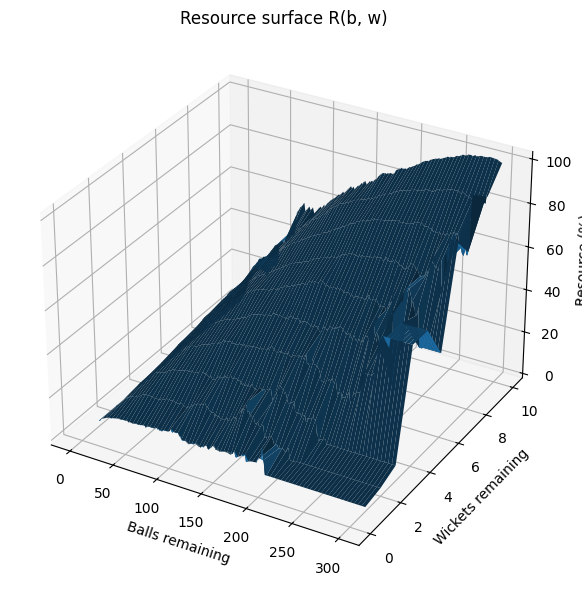

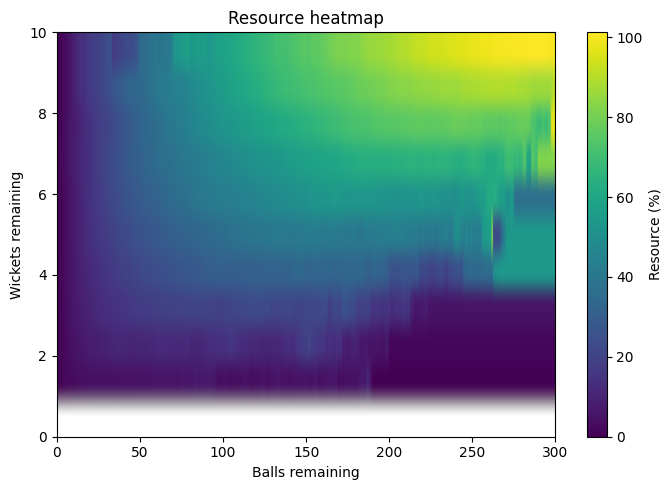

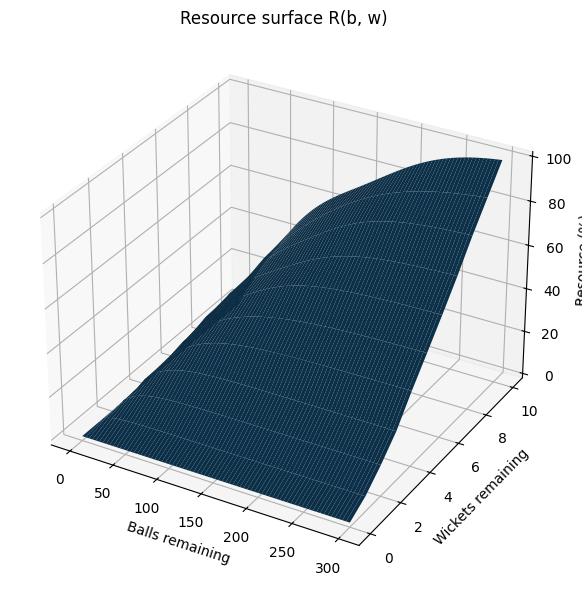

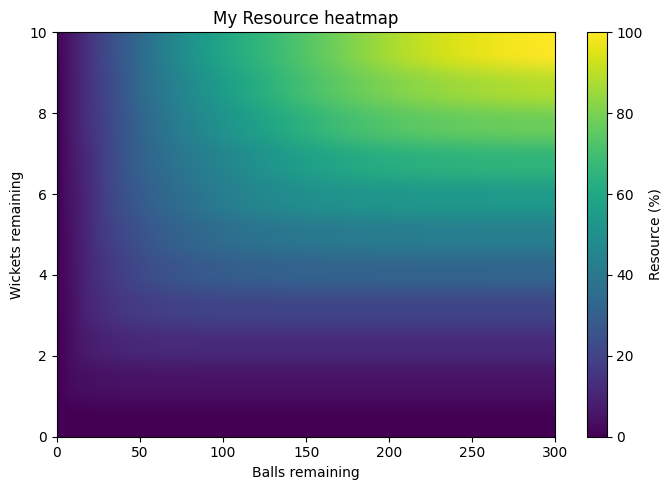

In [22]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- prepare dense grid ---
df = train.copy()
df = df[(df['b']>=0)&(df['b']<=300)&(df['w']>=0)&(df['w']<=10)]
df['b'] = df['b'].astype(int)              # optional bucketing
df['w'] = df['w'].astype(int)

# target = expected remaining runs from that state
# if you aggregated earlier, use mean per (b,w)
g = df.groupby(['b','w'], as_index=False)['runs'].mean().rename(columns={'runs':'Z'})

# g: columns ['b','w','Z'] already aggregated (mean per (b,w))
B = np.arange(0, 301)        # balls remaining
W = np.arange(0, 11)         # wickets remaining

# pivot to grid; fill small holes by nearest-forward fill
P = g.pivot_table(index='b', columns='w', values='Z', aggfunc='mean').reindex(index=B, columns=W)
P = P.sort_index().sort_index(axis=1)
P = P.interpolate(method='linear', axis=0).interpolate(method='linear', axis=1).fillna(method='bfill').fillna(method='ffill')

# normalize to resource percent if you want
R_z = 100.0 * P / float(P.loc[300, 10])  # or (300,0) based on your convention

# --- 3D surface ---
b_grid, w_grid = np.meshgrid(B, W, indexing='ij')
Z = R_z.values  # or P.values

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(b_grid, w_grid, Z, rstride=4, cstride=1, linewidth=0, antialiased=True)
ax.set_xlabel('Balls remaining')
ax.set_ylabel('Wickets remaining')
ax.set_zlabel('Resource (%)')  # or 'Expected runs'
ax.set_title('Resource surface R(b, w)')
plt.tight_layout(); plt.show()

# --- optional 2D heatmap view ---
plt.figure(figsize=(7,5))
plt.imshow(Z.T, origin='lower', aspect='auto', extent=[B.min(), B.max(), W.min(), W.max()])
plt.colorbar(label='Resource (%)')
plt.xlabel('Balls remaining'); plt.ylabel('Wickets remaining')
plt.title('Resource heatmap'); plt.tight_layout(); plt.show()


# --- 3D surface ---
b_grid, w_grid = np.meshgrid(B, W, indexing='ij')
R = myres_df.values
Z_my = R[::-1, ::-1].copy() # or P.values

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(b_grid, w_grid, Z_my, rstride=4, cstride=1, linewidth=0, antialiased=True)
ax.set_xlabel('Balls remaining')
ax.set_ylabel('Wickets remaining')
ax.set_zlabel('Resource (%)')  # or 'Expected runs'
ax.set_title('Resource surface R(b, w)')
plt.tight_layout(); plt.show()

# --- optional 2D heatmap view ---
plt.figure(figsize=(7,5))
plt.imshow(Z_my.T, origin='lower', aspect='auto', extent=[B.min(), B.max(), W.min(), W.max()])
plt.colorbar(label='Resource (%)')
plt.xlabel('Balls remaining'); plt.ylabel('Wickets remaining')
plt.title('My Resource heatmap'); plt.tight_layout(); plt.show()

In [23]:
def three_exp(b, pp, p):
    A1,k1,g1,A2,k2,g2,A3,k3,g3, eta = p
    pp = 0

    #u = np.clip((b / T_BALLS) + (eta*pp/60), 0.0, 1.0)
    u = np.clip((b / T_BALLS), 0.0, 1.0)
    ret =  (A1*(1-np.exp(-k1*u))**g1 +
            A2*(1-np.exp(-k2*u))**g2 +
            A3*(1-np.exp(-k3*u))**g3)
    return ret #**eta

rows = []
for w in sorted(fits):  # fits[w] = (A1,k1,g1,A2,k2,g2,A3,k3,g3)
    d = (train.loc[train['w']==w, ['b','runs', "pp"]]
               .groupby(['b', "pp"])
               .agg(runs=('runs','mean'), n=('runs','size'))
               .reset_index())
    if d.empty:
        continue
    b = d['b'].to_numpy(float)
    y = d['runs'].to_numpy(float)
    n = d['n'].to_numpy(float)
    pp = d["pp"].to_numpy(float)

    yhat = three_exp(b, pp, fits[w])
    err  = yhat - y

    mae  = np.mean(np.abs(err))
    mse  = np.mean(err**2)
    rmse = np.sqrt(mse)

    wmae  = np.sum(n*np.abs(err)) / np.sum(n)
    wmse  = np.sum(n*(err**2))    / np.sum(n)
    wrmse = np.sqrt(wmse)

    rows.append([w, len(b), int(n.sum()), mae, mse, rmse, wmae, wmse, wrmse])

metrics = pd.DataFrame(rows, columns=[
    'w','nbins','nsamples','MAE','MSE','RMSE','WMAE','WMSE','WRMSE'
]).sort_values('w')

print(metrics.to_string(index=False))

# Overall (weighted by samples across wickets)
overall_wmae  = (metrics['WMAE'] * metrics['nsamples']).sum() / metrics['nsamples'].sum()
overall_wrmse = np.sqrt((metrics['WMSE'] * metrics['nsamples']).sum() / metrics['nsamples'].sum())
print(f"\nOverall WMAE={overall_wmae:.3f}, Overall WRMSE={overall_wrmse:.3f}")

 w  nbins  nsamples      MAE        MSE      RMSE     WMAE     WMSE    WRMSE
 1    192      7583 1.688033   7.413091  2.722699 0.742075 1.634589 1.278510
 2    209     12212 5.086856  69.522528  8.338017 1.376700 7.549052 2.747554
 3    232     19144 5.814373 129.630781 11.385551 1.241927 7.025728 2.650609
 4    270     28249 6.049887 138.839057 11.782999 1.387360 7.851542 2.802060
 5    267     41597 3.791465  90.751985  9.526384 1.464685 4.198135 2.048935
 6    283     55735 3.792965  64.768955  8.047916 1.653461 5.780909 2.404352
 7    290     67859 1.972446  17.366033  4.167257 1.023893 2.616538 1.617572
 8    298     75512 2.421973  24.697650  4.969673 1.361857 4.506907 2.122948
 9    299     73140 1.765198   6.207784  2.491543 1.583112 5.058354 2.249078
10    268     67254 2.940827  25.549152  5.054617 1.103769 2.262602 1.504195

Overall WMAE=1.340, Overall WRMSE=2.111


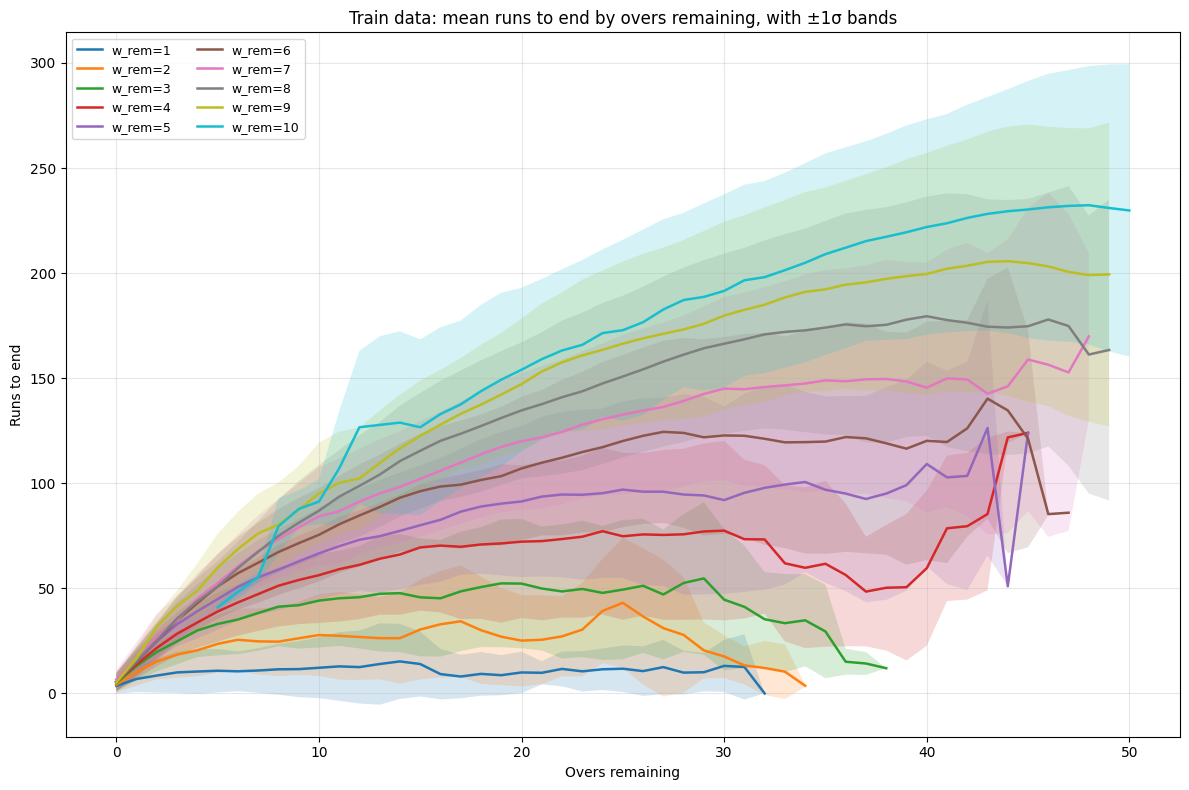

In [24]:
# Bigger plot + per-line std bands using raw train_df
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BALLS_PER_OVER = 6

def over_stats(train_df, w_rem):
    df = train_df.loc[train_df['w'] == w_rem, ['b', 'runs']].copy()
    df['overs_rem'] = np.floor_divide(df['b'].astype(int), BALLS_PER_OVER)
    g = df.groupby('overs_rem')['runs']
    mean = g.mean().sort_index(ascending=False)
    std  = g.std(ddof=1).reindex(mean.index).fillna(0.0)
    mean.index.name = 'overs_rem'
    return mean, std

fig, ax = plt.subplots(figsize=(12, 8))  # bigger figure
for w1 in range(1, 11):
    m, s = over_stats(train, w1)
    ax.plot(m.index, m.values, label=f"w_rem={w1}", linewidth=1.8)
    ax.fill_between(m.index, (m - s).values, (m + s).values, alpha=0.18)

ax.set_title("Train data: mean runs to end by overs remaining, with ±1σ bands")
ax.set_xlabel("Overs remaining")
ax.set_ylabel("Runs to end")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


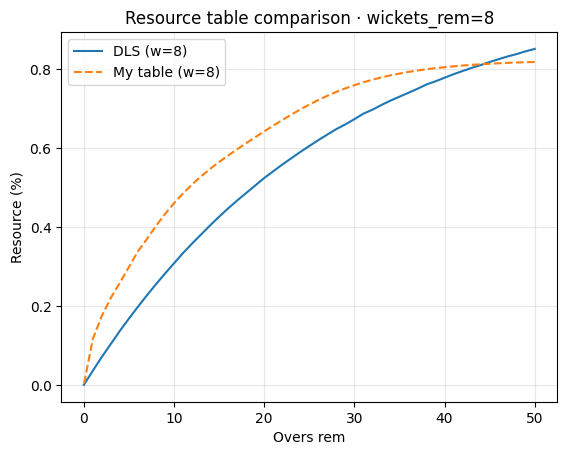

In [25]:

w = 8
#res_tab = to_overs_wickets(res_tab)

fig, ax = plt.subplots()
gamma = 0.8
ax.plot((dls_df[str(w)]/100), label=f"DLS (w={w})", linestyle='-')
ax.plot((res_tab[w]/100)**gamma, label=f"My table (w={w})", linestyle='--')

ax.set_title(f"Resource table comparison · wickets_rem={w}")
ax.set_xlabel("Overs rem")
ax.set_ylabel("Resource (%)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

## Visualize the results

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# assumes you have: predict_mu(theta, b, w, p) from the parametric model

def prep_cols(df):
    return df.rename(columns={
        'balls_rem':'b','wickets_rem':'w','pp_frac':'pp',
        'y_runs_to_end_no_extras':'runs'
    }).copy()

def plot_residual_heatmap_param(theta,
                                val_df: pd.DataFrame,
                                balls_per_over: int = 6,
                                agg: str = "mean",          # "mean" | "median"
                                stat: str = "res",          # "res" | "abs"  -> residual or absolute residual
                                min_count: int = 5,         # mask bins with < min_count samples
                                cmap: str = "coolwarm"):
    """
    Heatmap on (overs_remaining 0..50, wickets_remaining 0..10).
    Each bin aggregates validation residuals: truth - prediction.
    """
    df = prep_cols(val_df)
    # compute overs remaining as integer bins 0..50
    df['overs'] = (df['b'] / balls_per_over).astype(int).clip(0, 50)
    df['wkts']  = df['w'].astype(int).clip(0, 10)

    # predictions and residuals
    mu = predict_mu(theta, df['b'].to_numpy(float), df['w'].to_numpy(float), df['pp'].to_numpy(float), use_pp =True)
    res = df['runs'].to_numpy(float) - mu
    if stat == "abs":
        res = np.abs(res)

    df['res'] = res
    df['wt']  = df.get('weight', pd.Series(1.0, index=df.index)).astype(float).clip(1e-8, None)

    # weighted aggregator
    def wmean(x, w): return np.sum(w * x) / np.sum(w)
    def wmed(x, w):
        s = np.argsort(x); x=x[s]; w=w[s]
        cw = np.cumsum(w); cw /= cw[-1]
        return np.interp(0.5, cw, x)

    agg_fun = (lambda g: wmean(g['res'].values, g['wt'].values)) if agg=="mean" else \
              (lambda g: wmed (g['res'].values, g['wt'].values))

    grp = df.groupby(['overs','wkts']).apply(agg_fun).rename('stat').reset_index()
    cnt = df.groupby(['overs','wkts'])['wt'].count().rename('n').reset_index()
    G = pd.merge(grp, cnt, on=['overs','wkts'], how='left')

    # build grid [overs 0..50, wkts 0..10]
    M = np.full((51, 11), np.nan, dtype=float)
    for _, r in G.iterrows():
        if r['n'] >= min_count:
            M[int(r['overs']), int(r['wkts'])] = r['stat']

    # flip for plotting like earlier: overs 50→0 top→bottom, wickets 10→0 left→right
    Mplot = np.flipud(np.fliplr(M))

    # symmetric color scale around 0
    finite_vals = Mplot[np.isfinite(Mplot)]
    if finite_vals.size == 0:
        raise ValueError("No bins with enough data.")
    vmax = np.quantile(np.abs(finite_vals), 0.95)
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

    fig, ax = plt.subplots(figsize=(10,8))
    im = ax.imshow(Mplot, aspect="auto", origin="upper", cmap=cmap, norm=norm)

    # ticks
    ax.set_xticks(np.arange(Mplot.shape[1]))
    ax.set_xticklabels([str(10 - x) for x in range(Mplot.shape[1])])
    ax.set_xlabel("Wickets remaining")

    ax.set_yticks(np.arange(0, Mplot.shape[0], 5))
    ax.set_yticklabels([str(50 - y) for y in range(0, Mplot.shape[0], 5)])
    ax.set_ylabel("Overs remaining")

    # grid
    ax.set_xticks(np.arange(-0.5, Mplot.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, Mplot.shape[0], 1), minor=True)
    ax.grid(which="minor", color="k", alpha=0.1, linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    cbar = plt.colorbar(im, ax=ax)
    label = "Residual (truth - prediction)" if stat=="res" else "Absolute residual"
    cbar.set_label(f"{agg.title()} {label}")

    ax.set_title(f"Validation residual heatmap ({agg} {label})")
    plt.tight_layout()
    plt.show()
    return Mplot


In [27]:
# choose baseline; adjust PP length if yours != 60
R_mean_pp, overs, wkts = resource_grid_param(
    theta,
    balls_per_over=6,
    pp_frac_grid=(0,0.05, 0.1, 0.15, 0.2, 0.25, 0.3),
    max_pp_balls=60,
    baseline=(300,10,60)
)



# quick plot
import matplotlib.pyplot as plt
M = R_mean_pp[::-1, ::-1]

## Resource table to a df
res_tab  = pd.DataFrame(M)*100
res_tab.index, res_tab.columns = res_tab.index[::-1], res_tab.columns[::-1]


fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(M, aspect="auto", origin="upper", cmap="viridis", vmin=0.0, vmax=1.0)
ax.set_xticks(range(M.shape[1])); ax.set_xticklabels([str(10-x) for x in range(M.shape[1])])
ax.set_yticks(range(0,M.shape[0],5)); ax.set_yticklabels([str(50-y) for y in range(0,M.shape[0],5)])
ax.set_xlabel("Wickets remaining"); ax.set_ylabel("Overs remaining")
plt.colorbar(im, ax=ax, label="Resource fraction (avg over PP fractions)")
plt.tight_layout(); plt.show()
plt.close()

# Residuals over the val set
residuals = plot_residual_heatmap_param(theta, val_df, balls_per_over=6, agg="median", stat="res", min_count=5)
#For robustness: agg="median", stat="abs"


NameError: name 'resource_grid_param' is not defined

In [ ]:
pd.DataFrame(residuals)

## Metrics

In [28]:
# train metrics
mu_tr = predict_mu(theta, train['b'], train['w'], train['pp'])
mae_tr = mean_absolute_error(train['runs'], mu_tr, sample_weight=train['weight'])
rmse_tr = math.sqrt(mean_squared_error(train['runs'], mu_tr, sample_weight=train['weight'])) #, squared=False)

# val metrics
mu_va = predict_mu(theta, val['b'], val['w'], val['pp'])
mae_va = mean_absolute_error(val['runs'], mu_va, sample_weight=val['weight'])
rmse_va = math.sqrt(mean_squared_error(val['runs'], mu_va, sample_weight=val['weight'])) #, squared=False)

print({"train_mae": float(mae_tr), "train_rmse": float(rmse_tr),
       "val_mae": float(mae_va),   "val_rmse": float(rmse_va)})


NameError: name 'predict_mu' is not defined

## Original DLS Table

In [29]:
# @title
import pandas as pd

# rows: overs left 50..0 ; cols: wickets lost 0..9
data = {
  50:[100.0,93.4,85.1,74.9,62.7,49.0,34.9,22.0,11.9,4.7],
  49:[ 99.1,92.6,84.5,74.4,62.5,48.9,34.9,22.0,11.9,4.7],
  48:[ 98.1,91.7,83.8,74.0,62.2,48.4,34.9,22.0,11.9,4.7],
  47:[ 97.1,90.9,83.2,73.5,61.9,48.6,34.9,22.0,11.9,4.7],
  46:[ 96.0,90.0,82.5,73.0,61.6,48.4,34.8,22.0,11.9,4.7],
  45:[ 95.0,89.1,81.8,72.5,61.3,48.4,34.8,22.0,11.9,4.7],
  44:[ 93.9,88.2,81.0,72.0,61.0,48.3,34.8,22.0,11.9,4.7],
  43:[ 92.8,87.3,80.3,71.5,60.7,47.9,34.7,22.0,11.9,4.7],
  42:[ 91.7,86.3,79.5,70.9,60.3,47.9,34.7,22.0,11.9,4.7],
  41:[ 90.5,85.3,78.7,70.3,59.9,47.4,34.6,22.0,11.9,4.7],
  40:[ 89.3,84.2,77.8,69.6,59.5,47.0,34.6,22.0,11.9,4.7],
  39:[ 88.0,83.1,76.9,69.0,59.1,46.7,34.5,22.0,11.9,4.7],
  38:[ 86.7,82.0,76.1,68.3,58.7,46.3,34.4,22.0,11.9,4.7],
  37:[ 85.4,80.9,75.0,67.6,58.2,46.9,34.4,21.9,11.9,4.7],
  36:[ 84.0,79.6,74.0,66.8,57.7,46.4,34.3,21.9,11.9,4.7],
  35:[ 82.7,78.5,73.0,66.0,57.2,46.4,34.2,21.9,11.9,4.7],
  34:[ 81.3,77.2,72.0,65.2,56.6,45.9,34.1,21.9,11.9,4.7],
  33:[ 79.8,75.9,70.9,64.4,56.0,45.4,34.0,21.9,11.9,4.7],
  32:[ 78.3,74.6,69.7,63.5,55.4,45.0,33.9,21.9,11.9,4.7],
  31:[ 76.8,73.4,68.7,62.7,54.7,44.5,33.7,21.9,11.9,4.7],
  30:[ 75.1,71.8,67.3,61.6,54.1,44.3,33.5,21.8,11.9,4.7],
  29:[ 73.4,70.1,66.0,60.6,53.4,43.8,33.2,21.8,11.9,4.7],
  28:[ 71.8,68.8,64.8,59.5,52.6,43.3,33.2,21.8,11.9,4.7],
  27:[ 70.1,67.2,63.4,58.4,51.8,42.8,33.0,21.8,11.9,4.7],
  26:[ 68.3,65.6,62.0,57.2,50.9,42.3,32.8,21.7,11.9,4.7],
  25:[ 66.5,63.9,60.5,56.0,50.0,42.2,32.6,21.6,11.9,4.7],
  24:[ 64.6,62.2,59.0,54.7,49.0,41.6,32.3,21.6,11.9,4.7],
  23:[ 62.7,60.4,57.4,53.4,48.0,40.9,32.0,21.4,11.9,4.7],
  22:[ 60.7,58.6,55.8,52.0,47.0,40.2,31.6,21.4,11.9,4.7],
  21:[ 58.7,57.0,54.1,50.6,45.8,39.4,31.2,21.3,11.9,4.7],
  20:[ 56.6,54.8,52.4,49.1,44.6,38.6,30.8,21.2,11.9,4.7],
  19:[ 54.4,52.8,50.5,47.5,43.9,40.0,33.1,21.1,11.9,4.7],
  18:[ 52.2,50.7,48.6,45.9,42.0,36.8,29.8,20.9,11.9,4.7],
  17:[ 49.9,48.5,46.7,44.1,40.6,35.8,29.2,20.7,11.9,4.7],
  16:[ 47.6,46.3,44.7,42.3,39.1,34.7,28.5,20.5,11.8,4.7],
  15:[ 45.2,44.1,42.6,40.5,37.6,33.5,27.8,20.2,11.8,4.7],
  14:[ 42.7,41.7,40.4,38.6,36.0,32.3,26.9,19.8,11.7,4.7],
  13:[ 40.2,39.3,38.1,36.5,34.2,30.8,26.1,19.3,11.7,4.7],
  12:[ 37.6,36.8,35.8,34.3,32.3,29.4,25.1,19.0,11.6,4.7],
  11:[ 34.9,34.2,33.4,31.9,29.4,27.2,24.0,18.5,11.5,4.7],
  10:[ 32.1,31.6,30.8,29.8,28.3,26.1,22.8,17.9,11.4,4.7],
   9:[ 29.2,28.8,28.2,27.1,26.1,24.2,21.4,17.1,11.2,4.7],
   8:[ 26.4,26.0,25.5,24.8,23.8,22.3,19.9,16.2,11.0,4.7],
   7:[ 23.4,23.1,22.7,22.2,21.4,20.1,18.2,15.2,10.5,4.7],
   6:[ 20.3,20.1,19.8,19.4,18.8,17.8,16.4,13.9,10.2,4.6],
   5:[ 17.2,17.0,16.8,16.5,16.1,15.4,14.3,12.5, 9.4,4.6],
   4:[ 14.0,13.9,13.7,13.5,13.2,12.7,12.0,10.7, 8.4,4.6],
   3:[ 10.6,10.5,10.4,10.3,10.2, 9.9, 9.5, 8.7, 7.2,4.2],
   2:[  7.2, 7.1, 7.1, 7.0, 6.8, 6.6, 6.2, 6.0, 5.5,3.7],
   1:[  3.6, 3.6, 3.6, 3.6, 3.5, 3.5, 3.4, 3.6, 3.2,2.5],
   0:[  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.0],
}

# build DataFrame with desired ordering
dls_df = pd.DataFrame.from_dict(data, orient="index").sort_index(ascending=False)
dls_df.index.name = "overs_left"
dls_df.columns = pd.Index(range(10), name="wickets_lost")

dls_df.columns = [str(int(x) + 1) for x in dls_df.columns[::-1]]
dls_df["0"] = 0
dls_df


,10,9,8,7,6,5,4,3,2,1,0
overs_left,,,,,,,,,,,
50,100.0,93.4,85.1,74.9,62.7,49.0,34.9,22.0,11.9,4.7,0
49,99.1,92.6,84.5,74.4,62.5,48.9,34.9,22.0,11.9,4.7,0
48,98.1,91.7,83.8,74.0,62.2,48.4,34.9,22.0,11.9,4.7,0
47,97.1,90.9,83.2,73.5,61.9,48.6,34.9,22.0,11.9,4.7,0
46,96.0,90.0,82.5,73.0,61.6,48.4,34.8,22.0,11.9,4.7,0
45,95.0,89.1,81.8,72.5,61.3,48.4,34.8,22.0,11.9,4.7,0
44,93.9,88.2,81.0,72.0,61.0,48.3,34.8,22.0,11.9,4.7,0
43,92.8,87.3,80.3,71.5,60.7,47.9,34.7,22.0,11.9,4.7,0
42,91.7,86.3,79.5,70.9,60.3,47.9,34.7,22.0,11.9,4.7,0


In [30]:
## Matching rows and columns
res_tab.index = dls_df.index
res_tab.columns = dls_df.columns

In [31]:
res_tab - dls_df

,10,9,8,7,6,5,4,3,2,1,0
overs_left,,,,,,,,,,,
50,0.000000,-4.551725,-7.324967,-9.344266,-8.495465,-5.717922,-2.337406,-1.123111,0.423103,0.257454,0.0
49,0.713838,-3.894067,-6.776764,-8.877112,-8.315317,-5.633212,-2.348188,-1.123150,0.423102,0.257454,0.0
48,1.367534,-3.253681,-6.173695,-8.538544,-8.051980,-5.161465,-2.367092,-1.123229,0.423098,0.257454,0.0
47,1.980464,-2.736311,-5.683089,-8.107827,-7.792609,-5.392788,-2.386630,-1.123329,0.423094,0.257454,0.0
46,2.648416,-2.143848,-5.106635,-7.686028,-7.537649,-5.227517,-2.306874,-1.123453,0.423088,0.257454,0.0
45,3.166924,-1.578310,-4.546253,-7.274366,-7.287601,-5.266019,-2.327910,-1.123609,0.423080,0.257454,0.0
44,3.731297,-1.041844,-3.904127,-6.874231,-7.043025,-5.208706,-2.349835,-1.123804,0.423069,0.257454,0.0
43,4.236686,-0.536729,-3.382736,-6.487209,-6.804556,-4.856033,-2.272766,-1.124049,0.423055,0.257454,0.0
42,4.678161,0.034627,-2.784888,-6.015111,-6.472906,-4.908505,-2.296837,-1.124355,0.423036,0.257454,0.0


## Finding train set noise (lower errror bound)

In [32]:
# @title
# y: final runs from state; X has balls_remaining b, wickets_in_hand w
import pandas as pd
import numpy as np

# assume df has columns: balls_rem, wkts_rem, pp_balls_rem, final_runs
def find_noise(df):
  df["overs_rem"] = df["balls_rem"] // 6  # integer overs remaining

  # define bins
  over_bins = pd.interval_range(start=0, end=50, freq=1, closed="right")  # adjust range/freq
  df["over_bin"] = pd.cut(df["overs_rem"], bins=over_bins)
  df["wkt_bin"]  = pd.cut(df["wickets_rem"], bins=range(0,11,1), right=True)

  # group and compute std and sample count
  stats = (
      df.groupby(["over_bin", "wkt_bin"])["y_runs_to_end_no_extras"]
        .agg(["count", "mean", "std"])
        .reset_index()
  )

  # estimate irreducible MAE lower bound
  stats["mae_lb"] = np.sqrt(2/np.pi) * stats["std"]
  return stats

val_stats = find_noise(val_df)
train_stats = find_noise(train_df)

print(f"train noise :  {np.nanmean(train_stats["mae_lb"])}")
print(f"val noise   :  {np.nanmean(val_stats["mae_lb"])}")

/tmp/ipython-input-1904449665.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["over_bin", "wkt_bin"])["y_runs_to_end_no_extras"]


train noise :  25.92786154994833
val noise   :  23.917278705036697


/tmp/ipython-input-1904449665.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["over_bin", "wkt_bin"])["y_runs_to_end_no_extras"]


## Eval on 2nd innings

In [33]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from functools import partial
def evaluate_resource_accuracy(
    df,
    resource_fn,
    overs_limit=50,
    balls_per_over=6,
    pp_balls=60,
    start_over_eval=20,
    end_over_eval = 30,
    progress = False
):
    eps = 1e-9
    df = df.copy()
    df = df[df["legal_delivery"] == True]

    # Keep matches with both innings and at least start_over_eval overs in 2nd inns
    needed_balls = start_over_eval * balls_per_over
    if end_over_eval is None:
        end_over_eval = overs_limit
    end_balls = end_over_eval * balls_per_over
    g = df.groupby(["match_id", "innings"])
    has_inn1 = set(m for (m,i),_ in g if i==1)
    has_inn2 = set(m for (m,i),_ in g if i==2)
    cand_matches = has_inn1 & has_inn2

    def second_inns_len_ok(m):
        inn2 = df[(df.match_id==m) & (df.innings==2)]
        if inn2.empty: return False
        return (inn2["ball_idx_legal_ffill"].max() >= needed_balls) #& (inn2["ball_idx_legal_ffill"].max() <= end_balls)

    matches = [m for m in cand_matches if second_inns_len_ok(m)]
    if not matches:
        return (pd.DataFrame(), pd.DataFrame(), {"overall_accuracy": np.nan})

    rows = []
    match_rows = []

    TOT_BALLS = overs_limit * balls_per_over
    prog = tqdm if progress else lambda x: x
    for m in prog(matches):
        inn1 = df[(df.match_id==m) & (df.innings==1)].sort_values("ball_idx_legal_ffill")
        inn2 = df[(df.match_id==m) & (df.innings==2)].sort_values("ball_idx_legal_ffill")

        if inn1.empty or inn2.empty:
            continue

        # 1) Target without extras (sum of runs_no_extras in inns 1)
        target_no_extras = inn1["cum_runs_batter"].max() #inn1["runs_no_extras"].sum()
        chasing_score_no_extras = inn2["cum_runs_batter"].max()
        actual_win2 = int(chasing_score_no_extras > target_no_extras)

        # Resource used by batting team in inns 1
        balls_faced1 = int(inn1["ball_idx_legal_ffill"].max())
        wkts_down1   = int(inn1["wickets_down"].max())
        balls_rem1   = max(0, TOT_BALLS - balls_faced1)
        wkts_rem1    = max(0, 10 - wkts_down1)
        pp_rem1      = max(0, pp_balls - balls_faced1)
        R_rem1       = float(resource_fn(balls_rem1, wkts_rem1, pp_rem1))
        R_used1      = max(0.0, 100.0 - R_rem1)

        # Actual winner as 1 if chasing side won
        chasing_team = inn2["team_batting"].iloc[0]
        batting_team = inn1["team_batting"].iloc[0]
        match_winner = chasing_team if actual_win2 > 0 else batting_team
        # actual_win2  = int(chasing_team == match_winner)

        # 2–4) Iterate 2nd-innings balls from start_over_eval
        inn2_eval = inn2[(inn2["ball_idx_legal_ffill"] >= needed_balls) & (inn2["ball_idx_legal_ffill"] <= end_balls)]

        for _, r in inn2_eval.iterrows():
            balls_faced2 = int(r["ball_idx_legal_ffill"])
            balls_rem2   = max(0, TOT_BALLS - balls_faced2)
            wkts_rem2    = max(0, 10 - int(r["wickets_down"]))
            pp_rem2      = max(0, pp_balls - balls_faced2)

            R_rem2  = float(resource_fn(balls_rem2, wkts_rem2, pp_rem2))
            R_used2 = max(0.0, 100.0 - R_rem2)

            # Par score relative to 1st-innings resources used
            par_score = target_no_extras * (R_used2 / max(R_used1, eps))

            pred_win2 = int(r["cum_runs_batter"] > par_score)
            correct   = int(pred_win2 == actual_win2)

            overs_completed = balls_faced2 // balls_per_over
            overs_rem       = overs_limit - overs_completed

            rows.append({
                "match_id": m,
                "over": int(r["over"]),
                "balls_faced2": balls_faced2,
                "balls_rem2": balls_rem2,
                "wkts_rem2": wkts_rem2,
                "pp_rem2": pp_rem2,
                "par_score": par_score,
                "score": r["cum_runs_total"],
                "pred_win2": pred_win2,
                "actual_win2": actual_win2,
                "correct": correct,
                "overs_completed": overs_completed,
                "overs_rem": overs_rem,
            })

        # Per-match accuracy
        if len(rows) and rows[-1]["match_id"] == m:
            m_rows = [x for x in rows if x["match_id"] == m]
            acc_m  = np.mean([x["correct"] for x in m_rows])
            match_rows.append({
                "match_id": m,
                "n_obs": len(m_rows),
                "per_match_accuracy": acc_m,
                "actual_win2": actual_win2,
                "resource_used_by_1" : R_used1,
                "resource_used_by_2" : R_used2,
                "target_no_extras": target_no_extras,
            })

    df_preds = pd.DataFrame(rows)
    df_match = pd.DataFrame(match_rows)

    # 5) Global metrics and binned summaries
    overall_accuracy = float(df_preds["correct"].mean()) if not df_preds.empty else np.nan

    # Accuracy as a function of overs completed (end-of-over style bins)
    df_preds["over_bin"] = pd.cut(df_preds["overs_completed"], bins=list(range(start_over_eval, overs_limit+1, 5)), right=True)
    acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")

    # Accuracy by wickets remaining bins
    df_preds["wkt_bin"] = pd.cut(df_preds["wkts_rem2"], bins=[0,2,4,6,8,10], right=True)
    acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")

    # Bias toward first vs second (prediction tendency)
    bias = df_preds["pred_win2"].mean()  # >0.5 => favors chaser; <0.5 => favors defender

    metrics = {
        "overall_accuracy": overall_accuracy,
        "bias_chaser_pred_rate": float(bias),
        "acc_by_over_bin": acc_by_over_bin,
        "acc_by_wkt_bin": acc_by_wkt_bin,
    }

    return df_preds, df_match, metrics

def get_resource_dls(b, w, p):
  ov = b//6
  return dls_df[str(w)][int(ov)].item()

def predict_runs(fits_by_w, b, w, pp=0):
    p = fits_by_w[w]
    return exp2_model((np.asarray(b, float), np.asarray(pp, float)), *p)

def pred_res(res_df, b, w, pp):
    return res_df[w][b]

## Get the resource function
fits_2 = fits.copy()
fits[0] = (0, 0, 0, 0, 0, 0, 0, 0, 0)
get_resource = partial(pred_res, myres_df)


In [34]:
## Get the full balls df, removing incomplete/interrupted matches and extra balls. Only for men and matches after 2019-01-27
balls_men_full_match_df = balls_df_filtered[(balls_df_filtered["gender"] == "male") & (balls_df_filtered["legal_delivery"])].reset_index(drop = True)
val_date = d1 #"2019-02-16"
matches_after_val_date = balls_men_full_match_df[balls_men_full_match_df["date"] >= pd.Timestamp(val_date)]["match_id"]
balls_men_full_match_df = balls_men_full_match_df[balls_men_full_match_df["match_id"].isin(matches_after_val_date)].reset_index(drop = True)

## All are miscounted overs
mco_df = balls_men_full_match_df[balls_men_full_match_df["ball_idx_legal"] >= 301] #[["ball_idx_legal", "abs_legal_idx", "wickets_down", "match_id", "pp_frac", "wickets_this_ball"]]
balls_men_full_match_df = add_pp_frac_by_date_rules(balls_men_full_match_df[~balls_men_full_match_df["match_id"].isin(mco_df["match_id"])].reset_index(drop = True), jsons)
balls_men_full_match_df["pp_frac"] = (61 - balls_men_full_match_df["ball_idx_legal"]).clip(lower=0).astype(int)   # inclusive

balls_men_full_match_df["pp_frac"] = balls_men_full_match_df["pp_frac"].clip(0, 60)
balls_men_full_match_df = balls_men_full_match_df.reset_index(drop = True)

In [35]:
balls_men_full_match_df.columns

Index(['match_id', 'date', 'gender', 'match_type', 'balls_per_over', 'innings',
       'team_batting', 'over', 'ball_in_over_any', 'ball_idx_any',
       'legal_delivery', 'ball_idx_legal', 'runs_batter', 'runs_extras',
       'runs_total', 'runs_no_extras', 'wickets_this_ball', 'wickets_down',
       'cum_runs_total', 'cum_runs_batter', 'extras_bye', 'extras_legbye',
       'extras_noball', 'extras_wide', 'extras_penalty', 'innings_total_runs',
       'abs_legal_idx', 'winner', 'loser', 'is_initial_tie', 'no_result',
       'method', 'used_bowlout', 'used_eliminator', 'win_by_runs',
       'win_by_wickets', 'ball_idx_legal_ffill', 'pp_frac'],
      dtype='object')

In [36]:
df = balls_men_full_match_df[["match_id", "innings", "cum_runs_total", "cum_runs_batter", "innings_total_runs"]].groupby(["match_id", "innings"])
df = df.agg({"cum_runs_total": "max", "cum_runs_batter": "max", "innings_total_runs" : "max"}).reset_index()
df



,match_id,innings,cum_runs_total,cum_runs_batter,innings_total_runs
0,4097,1,289,264,289
1,4097,2,263,251,263
2,4099,1,418,407,418
3,4099,2,389,371,389
4,4102,1,236,231,236
...,...,...,...,...,...
1350,4925,2,243,239,243
1351,4926,1,269,253,269
1352,4926,2,270,262,270
1353,4927,1,143,140,143


In [37]:
df_preds, df_match, metrics = evaluate_resource_accuracy(
    df = balls_men_full_match_df,
    resource_fn = get_resource,
    overs_limit=50,
    balls_per_over=6,
    pp_balls=60,
    start_over_eval=20,
    end_over_eval = 50
)

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")


In [38]:
df_preds_dls, df_match_dls, metrics_dls = evaluate_resource_accuracy(
    df = balls_men_full_match_df,
    resource_fn = get_resource_dls,
    overs_limit=50,
    balls_per_over=6,
    pp_balls=60,
    start_over_eval=20,
    end_over_eval = 50
)

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")


In [ ]:
metrics_dls

{'overall_accuracy': 0.7486386123930762,
 'bias_chaser_pred_rate': 0.46097355526818445,
 'acc_by_over_bin':    over_bin  accuracy
 0  (20, 25]  0.722504
 1  (25, 30]  0.725331
 2  (30, 35]  0.736059
 3  (35, 40]  0.770519
 4  (40, 45]  0.788520
 5  (45, 50]  0.855028,
 'acc_by_wkt_bin':    wkt_bin  accuracy
 0   (0, 2]  0.938309
 1   (2, 4]  0.835940
 2   (4, 6]  0.748963
 3   (6, 8]  0.659175
 4  (8, 10]  0.602700}

In [ ]:
metrics

{'overall_accuracy': 0.7810034524077875,
 'bias_chaser_pred_rate': 0.33087354221784576,
 'acc_by_over_bin':    over_bin  accuracy
 0  (20, 25]  0.759656
 1  (25, 30]  0.766202
 2  (30, 35]  0.772419
 3  (35, 40]  0.783847
 4  (40, 45]  0.822750
 5  (45, 50]  0.869613,
 'acc_by_wkt_bin':    wkt_bin  accuracy
 0   (0, 2]  0.935837
 1   (2, 4]  0.856455
 2   (4, 6]  0.762465
 3   (6, 8]  0.720569
 4  (8, 10]  0.682006}

In [ ]:
df_match

,match_id,n_obs,per_match_accuracy,actual_win2,resource_used_by_1,resource_used_by_2,target_no_extras
0,4097,167,0.778443,0,100.0,100.000000,264
1,4099,169,0.556213,0,100.0,100.000000,407
2,4102,171,0.093567,1,100.0,96.402500,231
3,4104,114,1.000000,1,100.0,74.043068,224
4,4106,178,0.842697,0,100.0,100.000000,238
...,...,...,...,...,...,...,...
625,4923,14,1.000000,0,100.0,100.000000,282
626,4924,179,0.932961,0,100.0,99.996390,249
627,4925,176,0.414773,1,100.0,98.634907,218
628,4926,122,1.000000,1,100.0,76.983935,253


In [ ]:

print((df_match["per_match_accuracy"] > 0.4).mean())
print((df_match_dls["per_match_accuracy"]>0.4).mean())

0.819047619047619
0.8031746031746032


In [ ]:


print(df_match[df_match["actual_win2"] ==0]["per_match_accuracy"].mean())
print(df_match[df_match["actual_win2"] ==1]["per_match_accuracy"].mean())

0.8251804655849055
0.7489904078371147


In [ ]:
print(df_match_dls[df_match_dls["actual_win2"] ==0]["per_match_accuracy"].mean())
print(df_match_dls[df_match_dls["actual_win2"] ==1]["per_match_accuracy"].mean())

0.7267430996931807
0.8583712209450095


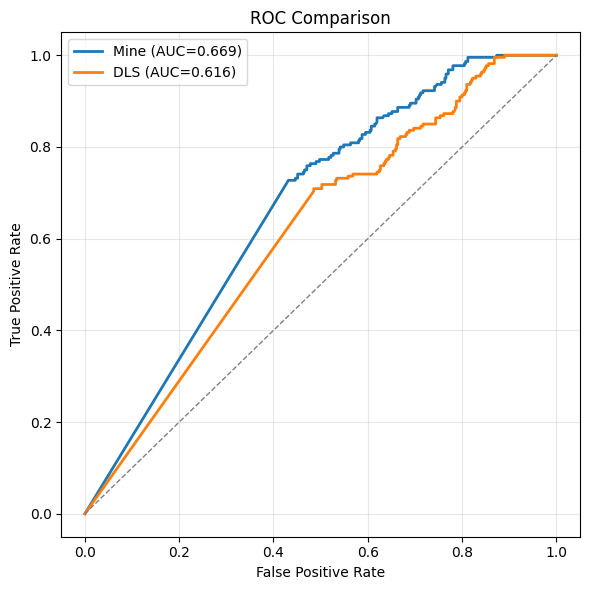

Mine: {'balanced_acc': np.float64(0.6028270509977827), 'overall_acc': 0.5063492063492063, 'auc': np.float64(0.6687084257206208), 'acc_true0': np.float64(0.28292682926829266), 'acc_true1': np.float64(0.9227272727272727), 'cm':         pred_0  pred_1
true_0     116     294
true_1      17     203}
DLS: {'balanced_acc': np.float64(0.5534368070953437), 'overall_acc': 0.45714285714285713, 'auc': np.float64(0.6160753880266076), 'acc_true0': np.float64(0.23414634146341465), 'acc_true1': np.float64(0.8727272727272727), 'cm':         pred_0  pred_1
true_0      96     314
true_1      28     192}


In [39]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

def eval_frame(df, actual='actual_win2', pred='per_match_accuracy', th=0.4, plot=True, label='Model'):
    y = df[actual].astype(int).values
    yprob = df[pred].astype(float).values
    yhat = (yprob > th).astype(int)

    ba = balanced_accuracy_score(y, yhat)
    oa = accuracy_score(y, yhat)
    auc = roc_auc_score(y, yprob)

    fpr, tpr, _ = roc_curve(y, yprob)
    if plot:
        plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC={auc:.3f})")

    cm = pd.DataFrame(confusion_matrix(y, yhat, labels=[0,1]),
                      index=['true_0','true_1'], columns=['pred_0','pred_1'])
    per_class_acc = cm.values.diagonal() / cm.sum(axis=1).values
    return {'balanced_acc':ba, 'overall_acc':oa, 'auc':auc,
            'acc_true0':per_class_acc[0], 'acc_true1':per_class_acc[1],
            'cm':cm}

# Example comparison
plt.figure(figsize=(6,6))
m1 = eval_frame(df_match, actual='actual_win2', pred='per_match_accuracy', th=0.4, plot=True, label='Mine')
m2 = eval_frame(df_match_dls, actual='actual_win2', pred='per_match_accuracy', th=0.4, plot=True, label='DLS')

plt.plot([0,1],[0,1],'--',color='gray',lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Mine:", m1)
print("DLS:", m2)


# assuming you have per-match predicted winners for both:
# # df_match_dls['pred_win2'], df_match['pred_win2']  in {0,1}

# ba_dls, oa_dls, cm_dls, pc_dls = eval_frame(df_match_dls)
# ba_mine, oa_mine, cm_mine, pc_mine = eval_frame(df_match)

# print("DLS  -> balanced_acc:", ba_dls, "overall_acc:", oa_dls, pc_dls, "\n", cm_dls, "\n")
# print("Mine -> balanced_acc:", ba_mine, "overall_acc:", oa_mine, pc_mine, "\n", cm_mine)


In [40]:
s = np.sum(1.0 - df_match[df_match["actual_win2"] ==1]["per_match_accuracy"]) + np.sum(1.0 - df_match[df_match["actual_win2"] ==0]["per_match_accuracy"])
s / len(df_match)

np.float64(0.25444762137567467)

In [41]:
s = np.sum(df_match_dls[df_match_dls["actual_win2"] ==1]["per_match_accuracy"]) + np.sum(1.0 - df_match_dls[df_match_dls["actual_win2"] ==0]["per_match_accuracy"])
s / len(df_match_dls)

np.float64(0.4775825360852349)

In [42]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_accuracy_heatmap(df_preds, min_n=20, title = None):
    # pivot: mean correctness per (overs_rem, wkts_rem2)
    acc = df_preds.pivot_table(values="correct",
                               index="overs_rem",
                               columns="wkts_rem2",
                               aggfunc="mean")
    n   = df_preds.pivot_table(values="correct",
                               index="overs_rem",
                               columns="wkts_rem2",
                               aggfunc="count")

    # full grid 50..0 overs, 10..0 wickets
    acc = acc.reindex(index=range(30, -1, -1), columns=range(10, -1, -1))
    n   = n.reindex_like(acc)

    # mask sparse cells
    acc_masked = acc.where(n >= min_n)

    fig, ax = plt.subplots(figsize=(8, 10))
    im = ax.imshow(acc_masked.values, origin="upper", aspect="auto",
                   vmin=0, vmax=1, interpolation="nearest")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Accuracy")

    # ticks
    ax.set_xticks(range(0, 11))
    ax.set_xticklabels(list(range(10, -1, -1)))   # 10..0 columns
    ax.set_yticks(range(0, 31, 5))
    ax.set_yticklabels(list(range(30, -1, -5)))   # 50..0 rows

    ax.set_xlabel("Wickets remaining")
    ax.set_ylabel("Overs remaining")
    if title is None:
      title = "Par-based win prediction accuracy"

    ax.set_title(title)

    # optional: outline sparse cells
    # ax.contour((n.values < min_n).astype(int), levels=[0.5], linewidths=0.6, colors="k")

    plt.tight_layout()

    return fig, ax


def plot_par_absdiff_heatmap(df_preds, title = None, min_n=20):
    """
    Plots mean absolute difference |score - par_score|
    across (overs_rem, wkts_rem2) grid.
    """

    df = df_preds.copy()
    df["abs_diff"] = (df["score"] - df["par_score"]).abs()

    # pivot: mean(|diff|) per (overs_rem, wkts_rem2)
    mad = df.pivot_table(values="abs_diff",
                         index="overs_rem",
                         columns="wkts_rem2",
                         aggfunc="mean")

    n = df.pivot_table(values="abs_diff",
                       index="overs_rem",
                       columns="wkts_rem2",
                       aggfunc="count")

    # ensure full grid (50→0 overs, 10→0 wickets)
    mad = mad.reindex(index=range(30, -1, -1), columns=range(10, -1, -1))
    n   = n.reindex_like(mad)
    mad_masked = mad.where(n >= min_n)

    fig, ax = plt.subplots(figsize=(8,10))
    im = ax.imshow(mad_masked.values, origin="upper", aspect="auto",
                   interpolation="nearest", cmap="viridis")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Mean |score − par| (runs)")

    ax.set_xticks(range(0, 11))
    ax.set_xticklabels(list(range(10, -1, -1)))
    ax.set_yticks(range(0, 31, 5))
    ax.set_yticklabels(list(range(30, -1, -5)))

    ax.set_xlabel("Wickets remaining")
    ax.set_ylabel("Overs remaining")
    if title is None:
      title = "Mean absolute deviation of actual score vs par score"
    ax.set_title(title)

    plt.tight_layout()
    return fig, ax


(<Figure size 800x1000 with 2 Axes>,
 <Axes: title={'center': 'Accuracy with My resource table'}, xlabel='Wickets remaining', ylabel='Overs remaining'>)

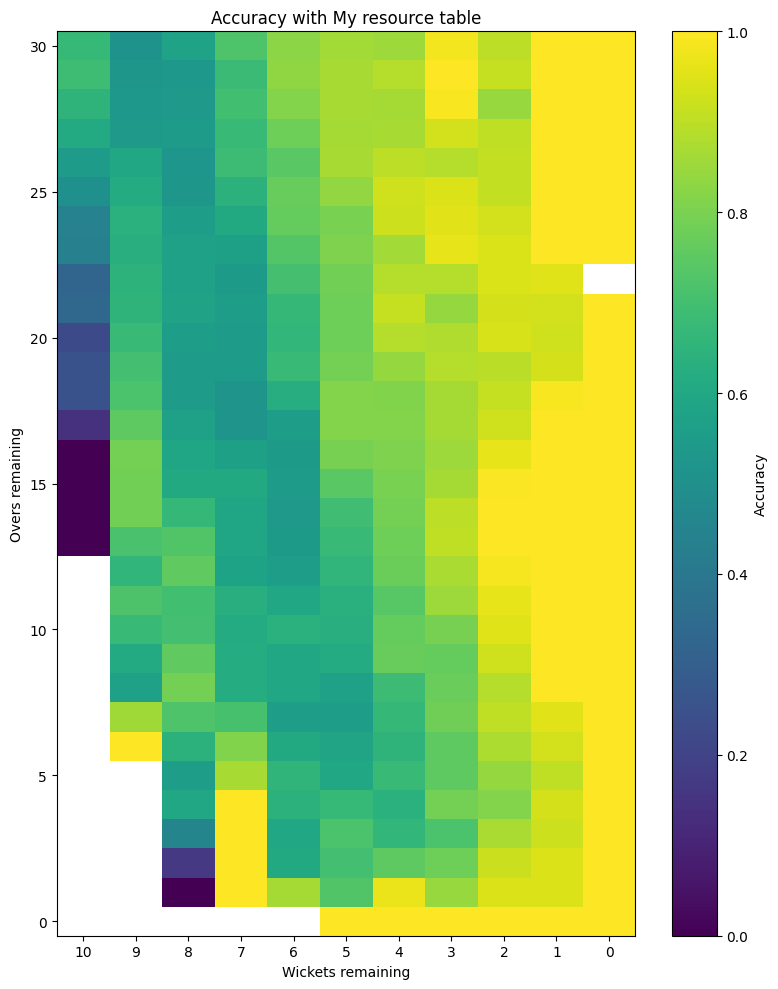

In [43]:
plot_accuracy_heatmap(df_preds, min_n=0, title = "Accuracy with My resource table")

(<Figure size 800x1000 with 2 Axes>,
 <Axes: title={'center': 'Accuracy with Orig DLS resource table'}, xlabel='Wickets remaining', ylabel='Overs remaining'>)

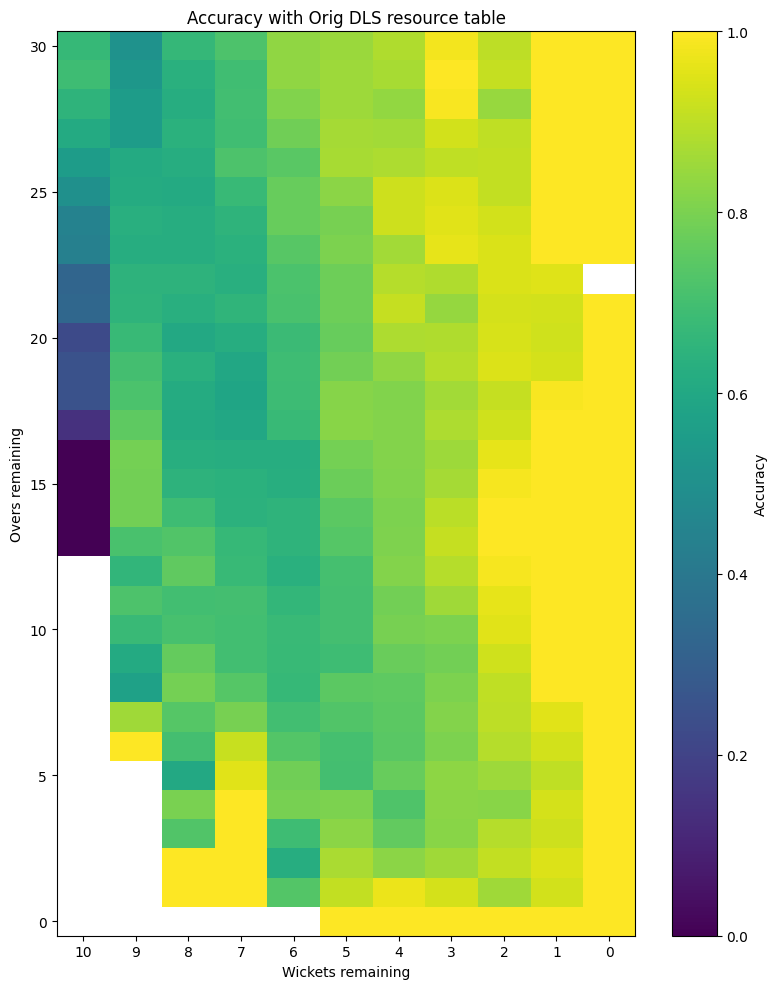

In [44]:
plot_accuracy_heatmap(df_preds_dls, min_n=0, title = "Accuracy with Orig DLS resource table")

(<Figure size 800x1000 with 2 Axes>,
 <Axes: title={'center': 'DLS, Mean abs deviations actual vs par score'}, xlabel='Wickets remaining', ylabel='Overs remaining'>)

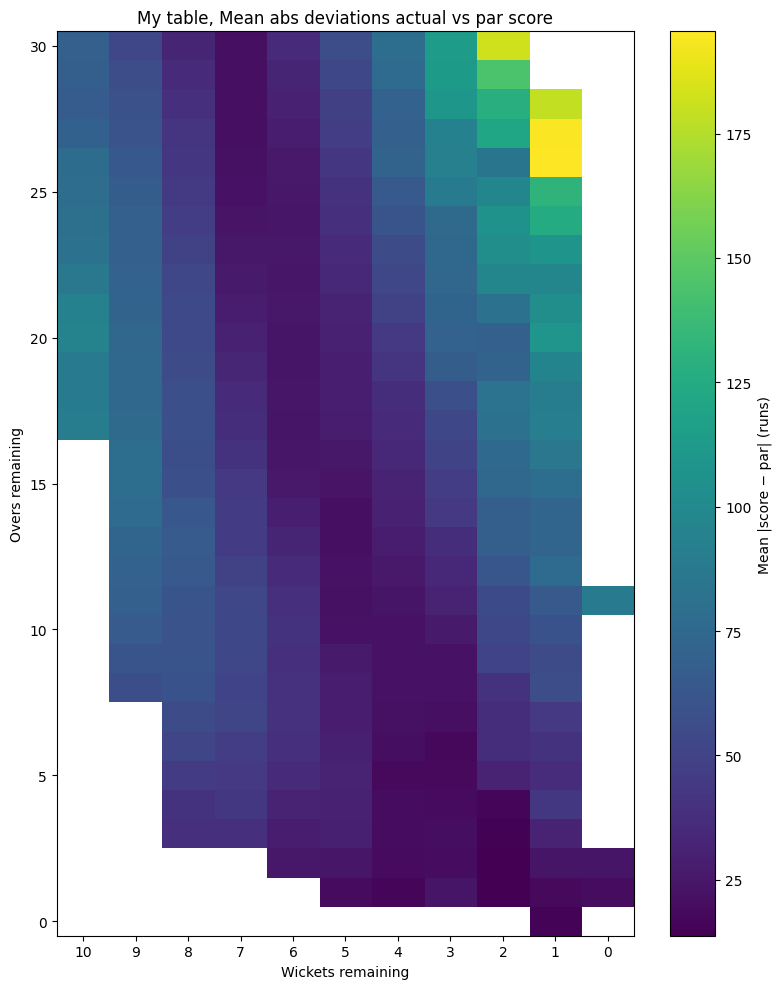

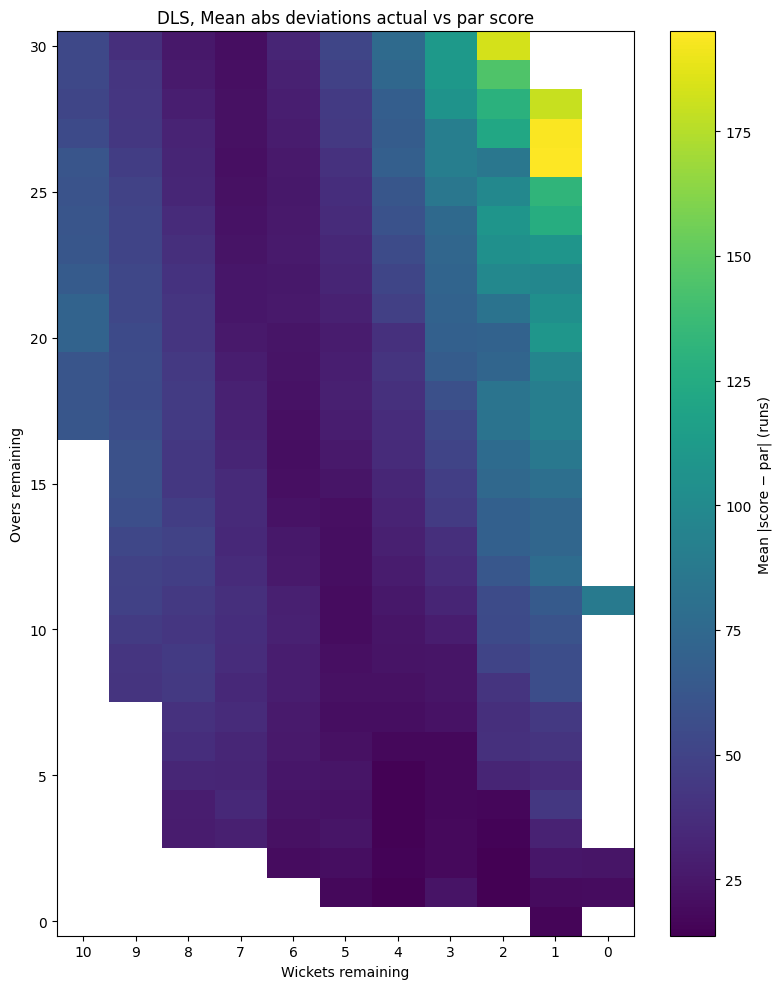

In [45]:


plot_par_absdiff_heatmap(df_preds, title = "My table, Mean abs deviations actual vs par score")

plot_par_absdiff_heatmap(df_preds_dls, title = "DLS, Mean abs deviations actual vs par score")

## Hyperparameter Optim

In [ ]:
## HYP VAL


from IPython.display import display, Math
import numpy as np

from IPython.display import display, Math
def get_df(adf, w_rem = 5, per_over = True):
  df = pd.DataFrame(adf[w_rem])
  # df: index = balls_remaining, column 'runs' (or use df.iloc[:,0] if unnamed)
  balls_per_over = 6
  if per_over:
    avg_runs_by_over = (
        df['runs']
        .groupby(np.floor_divide(df.index.astype(int), 6))
        .mean()
        .sort_index(ascending=False)   # optional
    )
    avg_runs_by_over.index.name = 'overs_rem'
    return avg_runs_by_over
  else:
    return df

import collections
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from scipy.optimize import curve_fit
T_BALLS = 300.0
def exp_model(b, A, k, g): return A * (1 - np.exp(-k * (b / T_BALLS)))**g
def exp2_model(X, A1, k1, g1, A2, k2, g2, A3, k3, g3, eta ):
      # X is a tuple/array: (b, pp)
    b, pp = X
    eta = 0
    u = np.clip(b / T_BALLS, 0.0, 1.0)
    ret = A1 * (1 - np.exp(-k1*u))**g1 + A2 * (1 - np.exp(-k2*u))**g2 + A3 * (1 - np.exp(-k3*u))**g3
    return ret #**eta


def phase_weight(b):
    if b>240: return 3.0   # emphasize PP
    if b>60: return 1.5    # middle
    return 2.5             # death
def to_overs_wickets(df):
    idx = df.index.astype(int)
    ow = (
        df.assign(overs_rem=idx // 6)     # 300..295 -> 50, 294..289 -> 49, ...
          .groupby('overs_rem', as_index=True)
          .mean()                         # average over each 6-ball block
          .sort_index(ascending=False)    # 50..0
    )
    # optional: keep wicket columns ordered 10..0
    ow = ow.reindex(sorted(ow.columns, reverse=True), axis=1)
    ow.index.name = 'overs_rem'
    ow.columns.name = 'wickets_rem'
    ow.loc[0] = 0
    return ow


def predict_runs(fits_by_w, b, w, pp=0):
  p = fits_by_w[w]
  return exp2_model((np.asarray(b, float), np.asarray(pp, float)), *p)

def pred_res(res_df, b, w, pp):
  return res_df[w][b]

def three_exp(b, pp, p):
    A1,k1,g1,A2,k2,g2,A3,k3,g3, eta = p
    pp = 0

    #u = np.clip((b / T_BALLS) + (eta*pp/60), 0.0, 1.0)
    u = np.clip((b / T_BALLS), 0.0, 1.0)
    ret =  (A1*(1-np.exp(-k1*u))**g1 +
            A2*(1-np.exp(-k2*u))**g2 +
            A3*(1-np.exp(-k3*u))**g3)
    return ret


fits = {}     # w -> (A,k,g)
fit_cov = {}  # w -> covariance or None
train_cpy = train.copy()
for w1 in range(1, 11):
    d = train_cpy[train_cpy['w']==w1][['b','pp','runs']].reset_index(drop = True).groupby(['b','pp']).agg(runs=('runs','mean'), n=('runs','size')).reset_index()
    if d.empty: continue
    b = d['b'].to_numpy(float); y = d['runs'].to_numpy(float)
    pp = d['pp'].to_numpy(float)
    sigma = (1.0 / np.sqrt(np.maximum(d['n'].to_numpy(float),1.0)))* np.array([phase_weight(b_rem) for b_rem in b])

    A0 = max(y.max(), 1.0) #max(np.percentile(y, 99.5), 1.0)
    #print(w1, A0)
    p0 = [0.6*A0, 0.08,1.2, 0.4*A0, 1.2, 1.2, 0.5*A0, 1.2, 1.2, 0.9]          # slow+fast
    # bounds: A>0, k>0, g in [0.5, 3.5]
    A_hi = max(5*A0, A0+10.0)
    bounds = ([A0*0.2, 1e-3, 1e-2, 1e-5, 1e-4, 1e-2, A0*0.3, 1e-3, 1e-2, 0.0], [A_hi, 4.0, 10.0, A_hi, 20.0, 55.0, A_hi*4, 5.0, 8.0, 1.0])

    (A1,k1,g1, A2,k2, g2,A3,k3, g3 , eta), _ = curve_fit(exp2_model, (b,pp), y, p0=p0, bounds=bounds,
                                  absolute_sigma=False, maxfev=20000, sigma=sigma,)
    fits[w1] = (A1.item(),k1.item(),g1.item(),A2.item(),k2.item(),g2.item(), A3.item(),k3.item(), g3.item(), eta.item())



    bx = np.linspace(0, 300, 301)
    ppx = np.array([0 for i in range(241)] + [i for i in range(1, 61)])

fits[0] = (0,0,0,0,0,0,0,0,0, 0)
max_balls = 300         # balls remaining



bx = np.linspace(1, 300, 300)
ppx = np.array([0 for i in range(240)] + [i for i in range(1, 61)])
rows = { w: [0] + [ q.item() for q in list(exp2_model((bx,ppx), *params ))] for w, params in fits.items()}
rows[0] = [0 for i in range(301)]
rows = collections.OrderedDict(sorted(rows.items()))
pred_df = pd.DataFrame(rows)




list_gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
wmae_list = []
balanced_acc_list  = []


for gamma in tqdm(list_gammas):
    myres_df = (pred_df**gamma)*100/((pred_df**gamma).max().max())
    myres_df = myres_df.iloc[::-1, ::-1]
    myres_df[:] = myres_df.apply(lambda x: sorted(x, reverse = True), axis=1, result_type='expand')

    # df: index = balls_remaining (300..0), columns = wickets_remaining (10..0)
    overs_wickets = to_overs_wickets(myres_df)
    ## Resource table to a df
    res_tab  = overs_wickets.copy()
    T_BALLS = 300  # or 120
    rows = []

    for w in sorted(fits):  # fits[w] = (A1,k1,g1,A2,k2,g2,A3,k3,g3)
        d = (train.loc[train['w']==w, ['b','runs', "pp"]]
                  .groupby(['b', "pp"])
                  .agg(runs=('runs','mean'), n=('runs','size'))
                  .reset_index())
        if d.empty:
            continue
        b = d['b'].to_numpy(float)
        y = d['runs'].to_numpy(float)
        n = d['n'].to_numpy(float)
        pp = d["pp"].to_numpy(float)

        yhat = three_exp(b, pp, fits[w])**gamma
        err  = yhat - y

        mae  = np.mean(np.abs(err))
        mse  = np.mean(err**2)
        rmse = np.sqrt(mse)

        wmae  = np.sum(n*np.abs(err)) / np.sum(n)
        wmse  = np.sum(n*(err**2))    / np.sum(n)
        wrmse = np.sqrt(wmse)

        rows.append([w, len(b), int(n.sum()), mae, mse, rmse, wmae, wmse, wrmse])


    metrics = pd.DataFrame(rows, columns=[
        'w','nbins','nsamples','MAE','MSE','RMSE','WMAE','WMSE','WRMSE'
    ]).sort_values('w')
    print(gamma)
    print(metrics.to_string(index=False))

    # Overall (weighted by samples across wickets)
    overall_wmae  = (metrics['WMAE'] * metrics['nsamples']).sum() / metrics['nsamples'].sum()
    overall_wrmse = np.sqrt((metrics['WMSE'] * metrics['nsamples']).sum() / metrics['nsamples'].sum())
    print(f"\nOverall WMAE={overall_wmae:.3f}, Overall WRMSE={overall_wrmse:.3f}")
    wmae_list.append(overall_wmae)


    get_resource = partial(pred_res, myres_df)
    df_preds, df_match, metrics = evaluate_resource_accuracy(
      df = balls_men_full_match_df,
      resource_fn = get_resource,
      overs_limit=50,
      balls_per_over=6,
      pp_balls=60,
      start_over_eval=20,
      end_over_eval = 50,
      progress = False,
    )

    m1 = eval_frame(df_match, actual='actual_win2', pred='per_match_accuracy', th=0.4, plot=False, label='Mine') #, progress = False)
    print("Mine:", m1)
    balanced_acc_list.append(m1["balanced_acc"])
    print("________________________________________________________________________")

m2 = eval_frame(df_match_dls, actual='actual_win2', pred='per_match_accuracy', th=0.4, plot=False, label='DLS') #, progress = False)
print("DLS : ", m2)



  0%|          | 0/9 [00:00<?, ?it/s]

0.1
 w  nbins  nsamples        MAE          MSE       RMSE       WMAE         WMSE      WRMSE
 1    192      7583   9.566078   100.285244  10.014252   8.072570    73.937556   8.598695
 2    209     12212  22.822004   606.111145  24.619325  19.662639   455.453526  21.341357
 3    232     19144  37.640945  1590.267503  39.878158  33.298831  1293.260018  35.961925
 4    270     28249  60.881045  4121.802268  64.201264  49.455149  2862.249910  53.499999
 5    267     41597  78.884448  6926.018509  83.222704  68.223081  5250.577373  72.460868
 6    283     55735  96.080605 10274.179986 101.361630  91.748000  9179.902479  95.811808
 7    290     67859 113.007391 14424.793908 120.103264 119.686686 15050.816942 122.681771
 8    298     75512 129.378902 19209.177660 138.597178 152.852001 24105.954786 155.260925
 9    299     73140 144.219324 23978.835077 154.851009 184.953583 34780.573190 186.495504
10    268     67254 170.068917 31681.543860 177.993101 221.503693 49320.323036 222.081794

Overa

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")
 11%|█         | 1/9 [00:15<02:07, 15.95s/it]

Mine: {'balanced_acc': np.float64(0.9865853658536585), 'overall_acc': 0.9825396825396825, 'auc': np.float64(0.9914634146341463), 'acc_true0': np.float64(0.973170731707317), 'acc_true1': np.float64(1.0), 'cm':         pred_0  pred_1
true_0     399      11
true_1       0     220}
________________________________________________________________________
0.2
 w  nbins  nsamples        MAE          MSE       RMSE       WMAE         WMSE      WRMSE
 1    192      7583   9.235792    93.791503   9.684601   7.768199    68.760850   8.292216
 2    209     12212  22.295022   581.667152  24.117777  19.198654   435.653388  20.872312
 3    232     19144  36.986586  1539.801715  39.240307  32.715833  1251.131876  35.371343
 4    270     28249  60.116020  4025.224251  63.444655  48.767523  2788.809990  52.809185
 5    267     41597  78.052224  6788.318320  82.391251  67.437915  5137.118020  71.673691
 6    283     55735  95.180512 10092.191456 100.459900  90.860139  9010.985593  94.926211
 7    290     

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")
 22%|██▏       | 2/9 [00:32<01:54, 16.33s/it]

Mine: {'balanced_acc': np.float64(0.9646341463414634), 'overall_acc': 0.953968253968254, 'auc': np.float64(0.9817073170731707), 'acc_true0': np.float64(0.9292682926829269), 'acc_true1': np.float64(1.0), 'cm':         pred_0  pred_1
true_0     381      29
true_1       0     220}
________________________________________________________________________
0.3
 w  nbins  nsamples        MAE          MSE       RMSE       WMAE         WMSE      WRMSE
 1    192      7583   8.815954    85.862958   9.266227   7.386627    62.501774   7.905806
 2    209     12212  21.564141   548.599201  23.422195  18.567407   409.150127  20.227460
 3    232     19144  36.032261  1467.481121  38.307716  31.882360  1191.422799  34.516993
 4    270     28249  58.956315  3880.127620  62.290670  47.747952  2680.189017  51.770542
 5    267     41597  76.761020  6575.694705  81.090657  66.237149  4964.132857  70.456603
 6    283     55735  93.754579  9804.581851  99.018089  89.462686  8746.180705  93.521017
 7    290     

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")
 33%|███▎      | 3/9 [00:48<01:37, 16.27s/it]

Mine: {'balanced_acc': np.float64(0.9439024390243902), 'overall_acc': 0.926984126984127, 'auc': np.float64(0.97059866962306), 'acc_true0': np.float64(0.8878048780487805), 'acc_true1': np.float64(1.0), 'cm':         pred_0  pred_1
true_0     364      46
true_1       0     220}
________________________________________________________________________
0.4
 w  nbins  nsamples        MAE          MSE       RMSE       WMAE         WMSE      WRMSE
 1    192      7583   8.282166    76.317839   8.736008   6.907879    55.035814   7.418613
 2    209     12212  20.589833   504.401805  22.458891  17.707957   374.053107  19.340453
 3    232     19144  34.639445  1364.930155  36.944961  30.688691  1107.567758  33.280141
 4    270     28249  57.196835  3663.934817  60.530445  46.233847  2520.793113  50.207501
 5    267     41597  74.755065  6249.755705  79.055396  64.397897  4702.303930  68.573347
 6    283     55735  91.492282  9353.117116  96.711515  87.260750  8333.877524  91.290074
 7    290     67

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")
 44%|████▍     | 4/9 [01:04<01:20, 16.18s/it]

Mine: {'balanced_acc': np.float64(0.9121951219512194), 'overall_acc': 0.8857142857142857, 'auc': np.float64(0.9566241685144125), 'acc_true0': np.float64(0.824390243902439), 'acc_true1': np.float64(1.0), 'cm':         pred_0  pred_1
true_0     338      72
true_1       0     220}
________________________________________________________________________
0.5
 w  nbins  nsamples        MAE          MSE       RMSE       WMAE         WMSE      WRMSE
 1    192      7583   7.603365    65.056105   8.065736   6.306745    46.302011   6.804558
 2    209     12212  19.307309   446.408208  21.128374  16.536447   328.333657  18.119979
 3    232     19144  32.605350  1221.932446  34.956150  28.976436   991.515010  31.488331
 4    270     28249  54.525958  3346.157400  57.845980  43.983173  2289.934403  47.853259
 5    267     41597  71.635064  5756.189945  75.869559  61.576601  4310.856898  65.657116
 6    283     55735  87.898371  8652.685158  93.019811  83.787704  7699.382173  87.746123
 7    290     

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")
 56%|█████▌    | 5/9 [01:21<01:05, 16.35s/it]

Mine: {'balanced_acc': np.float64(0.8609756097560975), 'overall_acc': 0.819047619047619, 'auc': np.float64(0.9340188470066518), 'acc_true0': np.float64(0.7219512195121951), 'acc_true1': np.float64(1.0), 'cm':         pred_0  pred_1
true_0     296     114
true_1       0     220}
________________________________________________________________________
0.6
 w  nbins  nsamples        MAE          MSE       RMSE       WMAE         WMSE      WRMSE
 1    192      7583   6.740490    52.164041   7.222468   5.553923    36.378301   6.031443
 2    209     12212  17.555479   372.501997  19.300311  14.936738   270.300778  16.440827
 3    232     19144  29.633013  1027.951934  32.061690  26.516743   834.698650  28.891152
 4    270     28249  50.464703  2889.596801  53.754970  40.626166  1962.887593  44.304487
 5    267     41597  66.777265  5024.297515  70.882279  57.243206  3737.859451  61.138036
 6    283     55735  82.182386  7587.982125  87.109024  78.304636  6742.587581  82.113261
 7    290     

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")
 67%|██████▋   | 6/9 [01:37<00:48, 16.30s/it]

Mine: {'balanced_acc': np.float64(0.8109756097560976), 'overall_acc': 0.753968253968254, 'auc': np.float64(0.89450110864745), 'acc_true0': np.float64(0.6219512195121951), 'acc_true1': np.float64(1.0), 'cm':         pred_0  pred_1
true_0     255     155
true_1       0     220}
________________________________________________________________________
0.7
 w  nbins  nsamples        MAE          MSE       RMSE       WMAE         WMSE      WRMSE
 1    192      7583   5.643438    38.098949   6.172435   4.610601    25.612474   5.060877
 2    209     12212  15.125349   282.840206  16.817854  12.748721   199.742564  14.133031
 3    232     19144  25.584497   777.115659  27.876794  22.982791   631.295884  25.125602
 4    270     28249  44.284883  2259.416522  47.533320  35.611690  1517.219715  38.951505
 5    267     41597  59.206708  3978.831701  63.077981  50.579233  2930.086993  54.130278
 6    283     55735  73.081816  6028.565590  77.643838  69.640685  5351.704478  73.155345
 7    290     67

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")
 78%|███████▊  | 7/9 [01:53<00:32, 16.18s/it]

Mine: {'balanced_acc': np.float64(0.7599223946784923), 'overall_acc': 0.6888888888888889, 'auc': np.float64(0.8513192904656319), 'acc_true0': np.float64(0.524390243902439), 'acc_true1': np.float64(0.9954545454545455), 'cm':         pred_0  pred_1
true_0     215     195
true_1       1     219}
________________________________________________________________________
0.8
 w  nbins  nsamples        MAE          MSE       RMSE       WMAE         WMSE      WRMSE
 1    192      7583   4.250208    24.008122   4.899808   3.424161    14.845342   3.852965
 2    209     12212  12.006987   183.677518  13.552768   9.775777   120.433336  10.974212
 3    232     19144  20.340630   481.460717  21.942213  17.908370   386.880422  19.669276
 4    270     28249  34.878195  1453.993416  38.131266  28.116617   953.245749  30.874678
 5    267     41597  47.398635  2589.641383  50.888519  40.319818  1871.152342  43.256818
 6    283     55735  58.579561  3905.608043  62.494864  55.939552  3469.526377  58.902686

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")
 89%|████████▉ | 8/9 [02:10<00:16, 16.28s/it]

Mine: {'balanced_acc': np.float64(0.7139135254988913), 'overall_acc': 0.6317460317460317, 'auc': np.float64(0.8010421286031042), 'acc_true0': np.float64(0.44146341463414634), 'acc_true1': np.float64(0.9863636363636363), 'cm':         pred_0  pred_1
true_0     181     229
true_1       3     217}
________________________________________________________________________
0.9
 w  nbins  nsamples       MAE         MSE      RMSE      WMAE        WMSE     WRMSE
 1    192      7583  2.660486   12.271292  3.503040  2.021775    5.785756  2.405360
 2    209     12212  8.339256   95.464499  9.770594  5.770606   45.385914  6.736907
 3    232     19144 12.945351  203.184299 14.254273 10.607802  139.338369 11.804167
 4    270     28249 20.702817  591.950041 24.330023 16.905693  350.027604 18.709025
 5    267     41597 29.354756 1026.328456 32.036361 24.511287  696.118824 26.384064
 6    283     55735 35.451934 1471.002086 38.353645 34.256866 1312.115390 36.223133
 7    290     67859 43.782512 2227.5614

/tmp/ipython-input-4006939642.py:130: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_over_bin = df_preds.groupby("over_bin")["correct"].mean().reset_index(name="accuracy")
/tmp/ipython-input-4006939642.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by_wkt_bin = df_preds.groupby("wkt_bin")["correct"].mean().reset_index(name="accuracy")
100%|██████████| 9/9 [02:26<00:00, 16.26s/it]

Mine: {'balanced_acc': np.float64(0.6610864745011087), 'overall_acc': 0.5698412698412698, 'auc': np.float64(0.7358758314855876), 'acc_true0': np.float64(0.35853658536585364), 'acc_true1': np.float64(0.9636363636363636), 'cm':         pred_0  pred_1
true_0     147     263
true_1       8     212}
________________________________________________________________________
DLS :  {'balanced_acc': np.float64(0.5534368070953437), 'overall_acc': 0.45714285714285713, 'auc': np.float64(0.6160753880266076), 'acc_true0': np.float64(0.23414634146341465), 'acc_true1': np.float64(0.8727272727272727), 'cm':         pred_0  pred_1
true_0      96     314
true_1      28     192}


In [46]:
dls_balanced_acc = []

for gamma in list_gammas:
  def get_resource_dls(gamma, b, w, p):
    ov = b//6
    return ((dls_df/100)**gamma)[str(w)][int(ov)].item()*100

  get_resource_DLS = partial(get_resource_dls, gamma)
  df_preds, df_match, metrics = evaluate_resource_accuracy(
    df = balls_men_full_match_df,
    resource_fn = get_resource_DLS,
    overs_limit=50,
    balls_per_over=6,
    pp_balls=60,
    start_over_eval=20,
    end_over_eval = 50,
    progress = False,
  )
  m2 = eval_frame(df_match_dls, actual='actual_win2', pred='per_match_accuracy', th=0.4, plot=False, label='DLS') #, progress = False)
  dls_balanced_acc.append(m2["balanced_acc"])

NameError: name 'list_gammas' is not defined

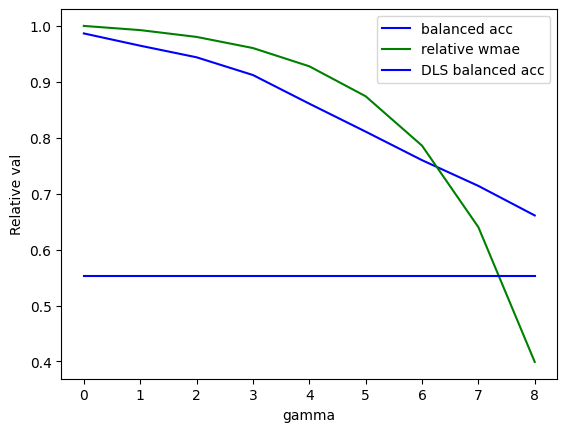

In [ ]:
plt.plot(balanced_acc_list, color = "b", label = "balanced acc")
plt.plot(wmae_list/max(wmae_list), color = "g", label = "relative wmae")
plt.plot(dls_balanced_acc, color = "b", label = "DLS balanced acc")
plt.xlabel("gamma")
plt.ylabel("Relative val")
plt.legend()